In [1]:
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import networkx as nx

### SHM

In [2]:
SAM = pd.read_csv("https://raw.githubusercontent.com/MuhammetRidvanInce/phD-Thesis/main/Enerji_SHM_Olustrma/aaa.csv", 
                  index_col = "index")
SAM.to_excel("SosyalHesaplarMatrisi.xlsx")

### Model Kurulumu

In [3]:
class CGE():
    
    def __init__(self, SAM):  
        self.SAM = SAM
        shm = self.SAM.loc

        # DIŞŞSAl DEĞİŞKENLER

        ## Üretim Faktörleri
        self.DCOBar = shm["dco", "raf"] 
        self.DNGBar = shm["dng", "bts"]
        self.Lbar   = shm["hh", "lab"]
        self.Kbar   = shm["hh", "cap"]

        ## Yabancı Tasarruf
        self.Sf     = shm["sav", "exp"]

        ## Dünya Fiyatları
        self.Pwe1, self.Pwe2, self.Pwe3, self.Pwe4, self.Pwe5, self.Pwer, self.Pweb, \
        self.Pwm1, self.Pwm2, self.Pwm3, self.Pwm4, self.Pwm5, self.Pwmr, \
        self.Pwmco, self.Pwmng = 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1

        ## Dönüşüm esneklikleri
        self.psi1 = 2
        self.psi2 = 2
        self.psi3 = 2
        self.psi4 = 2
        self.psi5 = 2
        self.psir = 0.6
        self.psib = 10 
        
        ## İkame Esneklikleri
        self.sigma1   = 2
        self.sigma2   = 2
        self.sigma3   = 2
        self.sigma4   = 2
        self.sigma5   = 2
        self.sigmar   = 2
        self.sigmaco  = 10
        self.sigmang  = 10

        # BAŞLANGIÇ DEĞERLERİ (BAZ TIL DEĞERLERİ)
        ## Fiyatlar
        px1, px2, px3, px4, px5, pxr, pxb, pz1, pz2, pz3, pz4, pz5, pzr, pzb, \
        pe1, pe2, pe3, pe4, pe5, per, peb, pd1, pd2, pd3, pd4, pd5, pdr, pdb, \
        pq1, pq2, pq3, pq4, pq5, pqr, pm1, pm2, pm3, pm4, pm5, pmr, pmco, pdco, \
        pco, pxco, pmng, pdng, png, pxng, epsilon, r, w = np.ones(51)

        ## Diğer Başlangıç (Baz Yıl) Değerleri
        Y = w*self.Lbar + r*self.Kbar
        OIL_INCOME = pdco*self.DCOBar + pdng*self.DNGBar
        L1 = shm["lab", "s1"]
        L2 = shm["lab", "s2"]
        L3 = shm["lab", "s3"]
        L4 = shm["lab", "s4"]
        L5 = shm["lab", "s5"]
        Lr = shm["lab", "raf"]
        Lb = shm["lab", "bts"]
        K1 = shm["cap", "s1"]
        K2 = shm["cap", "s2"]
        K3 = shm["cap", "s3"]
        K4 = shm["cap", "s4"]
        K5 = shm["cap", "s5"]
        Kr = shm["cap", "raf"]
        Kb = shm["cap", "bts"]
        X1 = L1 + K1
        X2 = L2 + K2
        X3 = L3 + K3
        X4 = L4 + K4
        X5 = L5 + K5
        Xr = Lr + Kr
        Xb = Lb + Kb
        MCOr = shm["mco","raf"]
        DCOr = shm["dco", "raf"]
        COr = MCOr + DCOr
        XCOr = Xr + COr
        MNGb = shm["mng", "bts"]
        DNGb = shm["dng", "bts"]
        NGb = MNGb + DNGb
        XNGb = Xb + NGb
        I11 = shm["s1", "s1"]
        I21 = shm["s2", "s1"]
        I31 = shm["s3", "s1"]
        I41 = shm["s4", "s1"]
        I51 = shm["s5", "s1"]
        Ir1 = shm["raf", "s1"]
        Ib1 = shm["bts", "s1"]
        I12 = shm["s1", "s2"]
        I22 = shm["s2", "s2"]
        I32 = shm["s3", "s2"]
        I42 = shm["s4", "s2"]
        I52 = shm["s5", "s2"]
        Ir2 = shm["raf", "s2"]
        Ib2 = shm["bts", "s2"]
        I13 = shm["s1", "s3"]
        I23 = shm["s2", "s3"]
        I33 = shm["s3", "s3"]
        I43 = shm["s4", "s3"]
        I53 = shm["s5", "s3"]
        Ir3 = shm["raf", "s3"]
        Ib3 = shm["bts", "s3"]
        I14 = shm["s1", "s4"]
        I24 = shm["s2", "s4"]
        I34 = shm["s3", "s4"]
        I44 = shm["s4", "s4"]
        I54 = shm["s5", "s4"]
        Ir4 = shm["raf", "s4"]
        Ib4 = shm["bts", "s4"]
        I15 = shm["s1", "s5"]
        I25 = shm["s2", "s5"]
        I35 = shm["s3", "s5"]
        I45 = shm["s4", "s5"]
        I55 = shm["s5", "s5"]
        Ir5 = shm["raf", "s5"]
        Ib5 = shm["bts", "s5"]
        I1r = shm["s1", "raf"]
        I2r = shm["s2", "raf"]
        I3r = shm["s3", "raf"]
        I4r = shm["s4", "raf"]
        I5r = shm["s5", "raf"]
        Irr = shm["raf", "raf"]
        Ibr = shm["bts", "raf"]
        I1b = shm["s1", "bts"]
        I2b = shm["s2", "bts"]
        I3b = shm["s3", "bts"]
        I4b = shm["s4", "bts"]
        I5b = shm["s5", "bts"]
        Irb = shm["raf", "bts"]
        Ibb = shm["bts", "bts"]
        Z1 = X1 + I11 + I21 + I31 + I41 + I51 + Ir1 + Ib1
        Z2 = X2 + I12 + I22 + I32 + I42 + I52 + Ir2 + Ib2
        Z3 = X3 + I13 + I23 + I33 + I43 + I53 + Ir3 + Ib3
        Z4 = X4 + I14 + I24 + I34 + I44 + I54 + Ir4 + Ib4
        Z5 = X5 + I15 + I25 + I35 + I45 + I55 + Ir5 + Ib5
        Zr = XCOr + I1r + I2r + I3r + I4r + I5r + Irr + Ibr
        Zb = XNGb + I1b + I2b + I3b + I4b + I5b + Irb + Ibb
        E1 = shm["s1", "exp"]
        E2 = shm["s2", "exp"]
        E3 = shm["s3", "exp"]
        E4 = shm["s4", "exp"]
        E5 = shm["s5", "exp"]
        Er = shm["raf", "exp"]
        Eb = shm["bts", "exp"]
        M1 = shm["imp", "s1"]
        M2 = shm["imp", "s2"]
        M3 = shm["imp", "s3"]
        M4 = shm["imp", "s4"]
        M5 = shm["imp", "s5"]
        Mr = shm["imp", "raf"]
        Td = shm["dtax", "hh"]
        Tva1 = shm["gtax", "s1"]
        Tva2 = shm["gtax", "s2"]
        Tva3 = shm["gtax", "s3"]
        Tva4 = shm["gtax", "s4"]
        Tva5 = shm["gtax", "s5"]
        Tvar = shm["gtax", "raf"]
        Tvab = shm["gtax", "bts"]
        Tva = Tva1 + Tva2 + Tva3 + Tva4 + Tva5 + Tvar + Tvab
        Tz1 = shm["ptax", "s1"]
        Tz2 = shm["ptax", "s2"]
        Tz3 = shm["ptax", "s3"]
        Tz4 = shm["ptax", "s4"]
        Tz5 = shm["ptax", "s5"]
        Tzr = shm["ptax", "raf"]
        Tzb = shm["ptax", "bts"]
        Tz = Tz1 + Tz2 + Tz3 + Tz4 + Tz5 + Tzr + Tzb
        Tm1 = shm["trf", "s1"]
        Tm2 = shm["trf", "s2"]
        Tm3 = shm["trf", "s3"]
        Tm4 = shm["trf", "s4"]
        Tm5 = shm["trf", "s5"]
        Tm = Tm1 + Tm2 + Tm3 + Tm4 + Tm5 
        T = Td + Tz + Tva + Tm
        D1 = Z1 + (Tva1 + Tz1) - E1
        D2 = Z2 + (Tva2 + Tz2) - E2
        D3 = Z3 + (Tva3 + Tz3) - E3
        D4 = Z4 + (Tva4 + Tz4) - E4
        D5 = Z5 + (Tva5 + Tz5) - E5
        Dr = Zr + (Tvar + Tzr) - Er
        Db = Zb + (Tvab + Tzb) - Eb
        C1 = shm["s1", "hh"]
        C2 = shm["s2", "hh"]
        C3 = shm["s3", "hh"]
        C4 = shm["s4", "hh"]
        C5 = shm["s5", "hh"]
        Cr = shm["raf", "hh"]
        Cb = shm["bts", "hh"]
        TPAO1 = shm["s1", "TPAO"]
        TPAO2 = shm["s2", "TPAO"]
        TPAO3 = shm["s3", "TPAO"]
        TPAO4 = shm["s4", "TPAO"]
        TPAO5 = shm["s5", "TPAO"]
        G1 = shm["s1", "gov"]
        G2 = shm["s2", "gov"]
        G3 = shm["s3", "gov"]
        G4 = shm["s4", "gov"]
        G5 = shm["s5", "gov"]
        INV1 = shm["s1", "inv"]
        INV2 = shm["s2", "inv"]
        INV3 = shm["s3", "inv"]
        INV4 = shm["s4", "inv"]
        INV5 = shm["s5", "inv"]
        Q1 = C1 + TPAO1 + G1 + INV1 + I11 + I12 + I13 + I14 + I15 + I1r + I1b
        Q2 = C2 + TPAO2 + G2 + INV2 + I21 + I22 + I23 + I24 + I25 + I2r + I2b
        Q3 = C3 + TPAO3 + G3 + INV3 + I31 + I32 + I33 + I34 + I35 + I3r + I3b
        Q4 = C4 + TPAO4 + G4 + INV4 + I41 + I42 + I43 + I44 + I45 + I4r + I4b
        Q5 = C5 + TPAO5 + G5 + INV5 + I51 + I52 + I53 + I54 + I55 + I5r + I5b
        Qr = Cr + Ir1 + Ir2 + Ir3 + Ir4 + Ir5 + Irr + Irb
        Db = Cb + Ib1 + Ib2 + Ib3 + Ib4 + Ib5 + Ibr + Ibb
        Sp = shm["sav", "hh"]
        Sg = shm["sav", "gov"]
        S = Sp + Sg + self.Sf
        Yd = Y - Sp - Td
        
        # PARAMETRELERİN KALİBRASYONU
      
        self.td = Td / Y 
        self.tva1 = Tva1 / Z1
        self.tva2 = Tva2 / Z2
        self.tva3 = Tva3 / Z3
        self.tva4 = Tva4 / Z4
        self.tva5 = Tva5 / Z5
        self.tvar = Tvar / Zr
        self.tvab = Tvab / Zb

        self.tz1 = Tz1 / Z1
        self.tz2 = Tz2 / Z2
        self.tz3 = Tz3 / Z3
        self.tz4 = Tz4 / Z4
        self.tz5 = Tz5 / Z5
        self.tzr = Tzr / Zr
        self.tzb = Tzb / Zb

        self.tm1 = Tm1 / M1
        self.tm2 = Tm2 / M2
        self.tm3 = Tm3 / M3
        self.tm4 = Tm4 / M4
        self.tm5 = Tm5 / M5

        self.alphal1 = L1 / (L1 + K1)
        self.alphal2 = L2 / (L2 + K2)
        self.alphal3 = L3 / (L3 + K3)
        self.alphal4 = L4 / (L4 + K4)
        self.alphal5 = L5 / (L5 + K5)
        self.alphalr = Lr / (Lr + Kr)
        self.alphalb = Lb / (Lb + Kb)

        self.alphak1 = K1 / (L1 + K1)
        self.alphak2 = K2 / (L2 + K2)
        self.alphak3 = K3 / (L3 + K3)
        self.alphak4 = K4 / (L4 + K4)
        self.alphak5 = K5 / (L5 + K5)
        self.alphakr = Kr / (Lr + Kr)
        self.alphakb = Kb / (Lb + Kb)

        self.A1 = X1 / (L1**self.alphal1 * K1**self.alphak1)
        self.A2 = X2 / (L2**self.alphal2 * K2**self.alphak2)
        self.A3 = X3 / (L3**self.alphal3 * K3**self.alphak3)
        self.A4 = X4 / (L4**self.alphal4 * K4**self.alphak4)
        self.A5 = X5 / (L5**self.alphal5 * K5**self.alphak5)
        self.Ar = Xr / (Lr**self.alphalr * Kr**self.alphakr)
        self.Ab = Xb / (Lb**self.alphalb * Kb**self.alphakb)

        self.alphaxr = Xr / (Xr + COr)
        self.alphaco = COr / (Xr + COr)
        self.Axco = XCOr / (Xr**self.alphaxr * COr**self.alphaco)

        self.alphaxb = Xb / (Xb + NGb)
        self.alphang = NGb / (Xb + NGb)
        self.Axng = XNGb / (Xb**self.alphaxb * NGb**self.alphang)

        self.a11 = I11 / Z1
        self.a21 = I21 / Z1
        self.a31 = I31 / Z1
        self.a41 = I41 / Z1
        self.a51 = I51 / Z1
        self.ar1 = Ir1 / Z1
        self.ab1 = Ib1 / Z1
        self.a12 = I12 / Z2
        self.a22 = I22 / Z2
        self.a32 = I32 / Z2
        self.a42 = I42 / Z2
        self.a52 = I52 / Z2
        self.ar2 = Ir2 / Z2
        self.ab2 = Ib2 / Z2
        self.a13 = I13 / Z3
        self.a23 = I23 / Z3
        self.a33 = I33 / Z3
        self.a43 = I43 / Z3
        self.a53 = I53 / Z3
        self.ar3 = Ir3 / Z3
        self.ab3 = Ib3 / Z3
        self.a14 = I14 / Z4
        self.a24 = I24 / Z4
        self.a34 = I34 / Z4
        self.a44 = I44 / Z4
        self.a54 = I54 / Z4
        self.ar4 = Ir4 / Z4
        self.ab4 = Ib4 / Z4
        self.a15 = I15 / Z5
        self.a25 = I25 / Z5
        self.a35 = I35 / Z5
        self.a45 = I45 / Z5
        self.a55 = I55 / Z5
        self.ar5 = Ir5 / Z5
        self.ab5 = Ib5 / Z5
        self.a1r = I1r / Zr
        self.a2r = I2r / Zr
        self.a3r = I3r / Zr
        self.a4r = I4r / Zr
        self.a5r = I5r / Zr
        self.arr = Irr / Zr
        self.abr = Ibr / Zr
        self.a1b = I1b / Zb
        self.a2b = I2b / Zb
        self.a3b = I3b / Zb
        self.a4b = I4b / Zb
        self.a5b = I5b / Zb
        self.arb = Irb / Zb
        self.abb = Ibb / Zb

        self.x1 = X1 / Z1
        self.x2 = X2 / Z2
        self.x3 = X3 / Z3
        self.x4 = X4 / Z4
        self.x5 = X5 / Z5
        
        self.xcor = XCOr / Zr
        self.xngb = XNGb / Zb

        self.rho1 = (self.psi1 + 1) / self.psi1
        self.rho2 = (self.psi2 + 1) / self.psi2
        self.rho3 = (self.psi3 + 1) / self.psi3
        self.rho4 = (self.psi4 + 1) / self.psi4
        self.rho5 = (self.psi5 + 1) / self.psi5
        self.rhor = (self.psir + 1) / self.psir
        self.rhob = (self.psib + 1) / self.psib

        self.eta1 = (self.sigma1 - 1) / self.sigma1
        self.eta2 = (self.sigma2 - 1) / self.sigma2
        self.eta3 = (self.sigma3 - 1) / self.sigma3
        self.eta4 = (self.sigma4 - 1) / self.sigma4
        self.eta5 = (self.sigma5 - 1) / self.sigma5
        self.etar = (self.sigmar - 1) / self.sigmar
        self.etaco = (self.sigmaco - 1) / self.sigmaco
        self.etang = (self.sigmang - 1) / self.sigmang


        self.e1 = E1**(1-self.rho1) / (E1**(1-self.rho1) + D1**(1-self.rho1))
        self.e2 = E2**(1-self.rho2) / (E2**(1-self.rho2) + D2**(1-self.rho2))
        self.e3 = E3**(1-self.rho3) / (E3**(1-self.rho3) + D3**(1-self.rho3))
        self.e4 = E4**(1-self.rho4) / (E4**(1-self.rho4) + D4**(1-self.rho4))
        self.e5 = E5**(1-self.rho5) / (E5**(1-self.rho5) + D5**(1-self.rho5))
        self.er = Er**(1-self.rhor) / (Er**(1-self.rhor) + Dr**(1-self.rhor))
        self.eb = Eb**(1-self.rhob) / (Eb**(1-self.rhob) + Db**(1-self.rhob))

        self.dt1 = D1**(1-self.rho1) / (E1**(1-self.rho1) + D1**(1-self.rho1))
        self.dt2 = D2**(1-self.rho2) / (E2**(1-self.rho2) + D2**(1-self.rho2))
        self.dt3 = D3**(1-self.rho3) / (E3**(1-self.rho3) + D3**(1-self.rho3))
        self.dt4 = D4**(1-self.rho4) / (E4**(1-self.rho4) + D4**(1-self.rho4))
        self.dt5 = D5**(1-self.rho5) / (E5**(1-self.rho5) + D5**(1-self.rho5))
        self.dtr = Dr**(1-self.rhor) / (Er**(1-self.rhor) + Dr**(1-self.rhor))
        self.dtb = Db**(1-self.rhob) / (Eb**(1-self.rhob) + Db**(1-self.rhob))

        self.theta1 = Z1 / (self.e1*E1**self.rho1 + self.dt1*D1**self.rho1)**(1/self.rho1)
        self.theta2 = Z2 / (self.e2*E2**self.rho2 + self.dt2*D2**self.rho2)**(1/self.rho2)
        self.theta3 = Z3 / (self.e3*E3**self.rho3 + self.dt3*D3**self.rho3)**(1/self.rho3)
        self.theta4 = Z4 / (self.e4*E4**self.rho4 + self.dt4*D4**self.rho4)**(1/self.rho4)
        self.theta5 = Z5 / (self.e5*E5**self.rho5 + self.dt5*D5**self.rho5)**(1/self.rho5)
        self.thetar = Zr / (self.er*Er**self.rhor + self.dtr*Dr**self.rhor)**(1/self.rhor)
        self.thetab = Zb / (self.eb*Eb**self.rhob + self.dtb*Db**self.rhob)**(1/self.rhob)

        self.m1   = (1+self.tm1)*M1**(1-self.eta1) / ((1+self.tm1)*M1**(1-self.eta1) + D1**(1-self.eta1))
        self.m2   = (1+self.tm2)*M2**(1-self.eta2) / ((1+self.tm2)*M2**(1-self.eta2) + D2**(1-self.eta2))
        self.m3   = (1+self.tm3)*M3**(1-self.eta3) / ((1+self.tm3)*M3**(1-self.eta3) + D3**(1-self.eta3))
        self.m4   = (1+self.tm4)*M4**(1-self.eta4) / ((1+self.tm4)*M4**(1-self.eta4) + D4**(1-self.eta4))
        self.m5   = (1+self.tm5)*M5**(1-self.eta5) / ((1+self.tm5)*M5**(1-self.eta5) + D5**(1-self.eta5))
        self.mr   = Mr**(1-self.etar) / (Mr**(1-self.etar) + Dr**(1-self.etar))
        self.mcor = MCOr**(1-self.etaco) / (MCOr**(1-self.etaco) + DCOr**(1-self.etaco))
        self.mngb = MNGb**(1-self.etang) / (MNGb**(1-self.etang) + DNGb**(1-self.etang))

        self.m1   = (1+self.tm1)*M1**(1-self.eta1) / ((1+self.tm1)*M1**(1-self.eta1) + D1**(1-self.eta1))
        self.m2   = (1+self.tm2)*M2**(1-self.eta2) / ((1+self.tm2)*M2**(1-self.eta2) + D2**(1-self.eta2))
        self.m3   = (1+self.tm3)*M3**(1-self.eta3) / ((1+self.tm3)*M3**(1-self.eta3) + D3**(1-self.eta3))
        self.m4   = (1+self.tm4)*M4**(1-self.eta4) / ((1+self.tm4)*M4**(1-self.eta4) + D4**(1-self.eta4))
        self.m5   = (1+self.tm5)*M5**(1-self.eta5) / ((1+self.tm5)*M5**(1-self.eta5) + D5**(1-self.eta5))
        self.mr   = Mr**(1-self.etar) / (Mr**(1-self.etar) + Dr**(1-self.etar))
        self.mcor = MCOr**(1-self.etaco) / (MCOr**(1-self.etaco) + DCOr**(1-self.etaco))
        self.mngb = MNGb**(1-self.etang) / (MNGb**(1-self.etang) + DNGb**(1-self.etang))

        self.da1   = D1**(1-self.eta1) / ((1+self.tm1)*M1**(1-self.eta1) + D1**(1-self.eta1))
        self.da2   = D2**(1-self.eta2) / ((1+self.tm2)*M2**(1-self.eta2) + D2**(1-self.eta2))
        self.da3   = D3**(1-self.eta3) / ((1+self.tm3)*M3**(1-self.eta3) + D3**(1-self.eta3))
        self.da4   = D4**(1-self.eta4) / ((1+self.tm4)*M4**(1-self.eta4) + D4**(1-self.eta4))
        self.da5   = D5**(1-self.eta5) / ((1+self.tm5)*M5**(1-self.eta5) + D5**(1-self.eta5))
        self.dar   = Dr**(1-self.etar) / (Mr**(1-self.etar) + Dr**(1-self.etar))
        self.dcor  = DCOr**(1-self.etaco) / (MCOr**(1-self.etaco) + DCOr**(1-self.etaco))
        self.dngb  = DNGb**(1-self.etang) / (MNGb**(1-self.etang) + DNGb**(1-self.etang))


        self.lambda1 = Q1 / (self.m1*M1**self.eta1 + self.da1*D1**self.eta1)**(1/self.eta1)
        self.lambda2 = Q2 / (self.m2*M2**self.eta2 + self.da2*D2**self.eta2)**(1/self.eta2)
        self.lambda3 = Q3 / (self.m3*M3**self.eta3 + self.da3*D3**self.eta3)**(1/self.eta3)
        self.lambda4 = Q4 / (self.m4*M4**self.eta4 + self.da4*D4**self.eta4)**(1/self.eta4)
        self.lambda5 = Q5 / (self.m5*M5**self.eta5 + self.da5*D5**self.eta5)**(1/self.eta5)
        self.lambdar = Qr / (self.mr*Mr**self.etar + self.dar*Dr**self.etar)**(1/self.etar)
        self.lambdaco = COr / (self.mcor*MCOr**self.etaco + self.dcor*DCOr**self.etaco)**(1/self.etaco)
        self.lambdang = NGb / (self.mngb*MNGb**self.etang + self.dngb*DNGb**self.etang)**(1/self.etang)

        self.c1 = C1 / Yd
        self.c2 = C2 / Yd
        self.c3 = C3 / Yd
        self.c4 = C4 / Yd
        self.c5 = C5 / Yd
        self.cr = Cr / Yd
        self.cb = Cb / Yd

        self.mu1 = TPAO1 / OIL_INCOME 
        self.mu2 = TPAO2 / OIL_INCOME 
        self.mu3 = TPAO3 / OIL_INCOME 
        self.mu4 = TPAO4 / OIL_INCOME 
        self.mu5 = TPAO5 / OIL_INCOME 

        self.g1 = G1 / (T - Sg)
        self.g2 = G2 / (T - Sg)
        self.g3 = G3 / (T - Sg)
        self.g4 = G4 / (T - Sg)
        self.g5 = G5 / (T - Sg)

        self.inv1 = INV1 / S
        self.inv2 = INV2 / S
        self.inv3 = INV3 / S
        self.inv4 = INV4 / S
        self.inv5 = INV5 / S

        self.sp = Sp / Y
        self.sg = Sg / T
        
        self.init_values =  [
            X1, L1, K1, I11, I21, I31, I41, I51, Ir1, Ib1, Z1,
            E1, D1, Q1, M1, X2, L2, K2, I12, I22, I32, I42, 
            I52, Ir2, Ib2, Z2, E2, D2, Q2, M2, X3, L3, K3, 
            I13, I23, I33, I43, I53, Ir3, Ib3, Z3, E3, D3, Q3, 
            M3, X4, L4, K4, I14, I24, I34, I44, I54, Ir4, 
            Ib4, Z4, E4, D4, Q4, M4, X5, L5, K5, I15, I25, 
            I35, I45, I55, Ir5, Ib5, Z5, E5, D5, Q5, M5, Xr, 
            Lr, Kr, COr, MCOr, DCOr, XCOr, I1r, I2r, I3r, I4r, 
            I5r, Irr, Ibr, Zr, Er, Dr, Qr, Mr, Xb, Lb, Kb, 
            NGb, MNGb, DNGb, XNGb, I1b, I2b, I3b, I4b, I5b, Irb, 
            Ibb, Zb, Eb, Db, C1, C2, C3, C4, C5, Cr, Cb, Y,
            Yd, TPAO1, TPAO2, TPAO3, TPAO4, TPAO5, OIL_INCOME, G1, G2, 
            G3, G4, G5, T, Td, Tz, Tva, Tm, Tz1, Tz2, Tz3, 
            Tz4, Tz5, Tzr, Tzb, Tva1, Tva2, Tva3, Tva4, Tva5, Tvar, 
            Tvab, Tm1, Tm2, Tm3, Tm4, Tm5, INV1, INV2, INV3, INV4, 
            INV5, S, Sp, Sg, px1, px2, px3, px4, px5, pxr, pxb, 
            pz1, pz2, pz3, pz4, pz5, pzr, pzb, pe1, pe2, pe3, 
            pe4, pe5, per, peb, pd1, pd2, pd3, pd4, pd5, pdr, pdb, 
            pq1, pq2, pq3, pq4, pq5, pqr, pm1, pm2, pm3, pm4, 
            pm5, pmr, pmco, pdco, pco, pxco, pmng, pdng, png, pxng, 
            epsilon, r 
        ]
        
        self.init_values_str = [
            "X1", "L1", "K1", "I11", "I21", "I31", "I41", "I51", "Ir1", "Ib1", "Z1", "E1", "D1", "Q1", "M1",
            "X2", "L2", "K2", "I12", "I22", "I32", "I42", "I52", "Ir2", "Ib2", "Z2", "E2", "D2", "Q2", "M2",
            "X3", "L3", "K3", "I13", "I23", "I33", "I43", "I53", "Ir3", "Ib3", "Z3", "E3", "D3", "Q3", "M3",
            "X4", "L4", "K4", "I14", "I24", "I34", "I44", "I54", "Ir4", "Ib4", "Z4", "E4", "D4", "Q4", "M4",
            "X5", "L5", "K5", "I15", "I25", "I35", "I45", "I55", "Ir5", "Ib5", "Z5", "E5", "D5", "Q5", "M5",
            "Xr", "Lr", "Kr", "COr", "MCOr", "DCOr", "XCOr",
            "I1r", "I2r", "I3r", "I4r", "I5r", "Irr", "Ibr", "Zr", "Er", "Dr", "Qr", "Mr",
            "Xb", "Lb", "Kb", "NGb", "MNGb", "DNGb", "XNGb",
            "I1b", "I2b", "I3b", "I4b", "I5b", "Irb", "Ibb", "Zb", "Eb", "Db",
            "C1", "C2", "C3", "C4", "C5", "Cr", "Cb", "Y", "Yd",
            "TPAO1", "TPAO2", "TPAO3", "TPAO4", "TPAO5", "OIL_INCOME",
            "G1", "G2", "G3", "G4", "G5", "T", "Td", "Tz", "Tva",
            "Tm", "Tz1", "Tz2", "Tz3", "Tz4", "Tz5", "Tzr", "Tzb", 
            "Tva1", "Tva2", "Tva3", "Tva4", "Tva5", "Tvar", "Tvab", "Tm1", "Tm2", "Tm3", "Tm4", "Tm5",
            "INV1", "INV2", "INV3", "INV4", "INV5", "S", "Sp", "Sg",
            "px1", "px2", "px3", "px4", "px5", "pxr", "pxb", "pz1",
            "pz2", "pz3", "pz4", "pz5", "pzr", "pzb", 
            "pe1", "pe2", "pe3", "pe4", "pe5", "per", 
            "peb", "pd1", "pd2", "pd3", "pd4", "pd5",
            "pdr", "pdb", "pq1", "pq2", "pq3", "pq4",
            "pq5", "pqr", "pm1", "pm2", "pm3", "pm4",
            "pm5", "pmr", "pmco", "pdco", "pco", "pxco",
            "pmng", "pdng", "png", "pxng", "epsilon", "r",     
        ]
        
        self.parameters_str = [ "td" ,
                                'tva1' ,
                                'tva2' ,
                                'tva3' ,
                                'tva4' ,
                                "tva5" ,
                                "tvar" ,
                                "tvab" ,
                                "tz1" ,
                                "tz2" ,
                                "tz3" ,
                                "tz4" ,
                                "tz5" ,
                                "tzr" ,
                                "tzb" ,
                                "tm1" ,
                                "tm2" ,
                                "tm3" ,
                                "tm4" ,
                                "tm5" ,
                                "alphal1" ,
                                "alphal2" ,
                                "alphal3" ,
                                "alphal4" ,
                                "alphal5" ,
                                "alphalr" ,
                                "alphalb" ,
                                "alphak1" ,
                                "alphak2" ,
                                "alphak3" ,
                                "alphak4" ,
                                "alphak5" ,
                                "alphakr" ,
                                "alphakb" ,
                                "A1" ,
                                "A2" ,
                                "A3" ,
                                "A4" ,
                                "A5" ,
                                "Ar" ,
                                "Ab" ,
                                "alphaxr" ,
                                "alphaco" ,
                                "Axco" ,
                                "alphaxb" ,
                                "alphang" ,
                                "Axng" ,
                                "a11" ,
                                "a21" ,
                                "a31" ,
                                "a41" ,
                                "a51" ,
                                "ar1" ,
                                "ab1" ,
                                "a12" ,
                                "a22" ,
                                "a32" ,
                                "a42" ,
                                "a52" ,
                                "ar2" ,
                                "ab2" ,
                                "a13" ,
                                "a23" ,
                                "a33" ,
                                "a43" ,
                                "a53" ,
                                "ar3" ,
                                "ab3" ,
                                "a14" ,
                                "a24" ,
                                "a34" ,
                                "a44" ,
                                "a54" ,
                                "ar4" ,
                                "ab4" ,
                                "a15" ,
                                "a25" ,
                                "a35" ,
                                "a45" ,
                                "a55" ,
                                "ar5" ,
                                "ab5" ,
                                "a1r" ,
                                "a2r" ,
                                "a3r" ,
                                "a4r" ,
                                "a5r" ,
                                "arr" ,
                                "abr" ,
                                "a1b" ,
                                "a2b" ,
                                "a3b" ,
                                "a4b" ,
                                "a5b" ,
                                "arb" ,
                                "abb" ,
                                "x1" ,
                                "x2" ,
                                "x3" ,
                                "x4" ,
                                "x5" ,
                                "xcor" ,
                                "xngb" ,
                                "rho1" ,
                                "rho2" ,
                                "rho3" ,
                                "rho4" ,
                                "rho5" ,
                                "rhor" ,
                                "rhob" ,
                                "eta1" ,
                                "eta2" ,
                                "eta3" ,
                                "eta4" ,
                                "eta5" ,
                                "etar" ,
                                "etaco" ,
                                "etang" ,
                                "e1" ,
                                "e2" ,
                                "e3" ,
                                "e4" ,
                                "e5" ,
                                "er" ,
                                "eb" ,
                                "dt1" ,
                                "dt2" ,
                                "dt3" ,
                                "dt4" ,
                                "dt5" ,
                                "dtr" ,
                                "dtb" ,
                                "theta1" ,
                                "theta2" ,
                                "theta3" ,
                                "theta4" ,
                                "theta5" ,
                                "thetar" ,
                                "thetab" ,
                                "m1"   ,
                                "m2"   ,
                                "m3"   ,
                                "m4"   ,
                                "m5"   ,
                                "mr"   ,
                                "mcor" ,
                                "mngb" ,
                                "m1"   ,
                                "m2"   ,
                                "m3"   ,
                                "m4"   ,
                                "m5"   ,
                                "mr"   ,
                                "mcor" ,
                                "mngb" ,
                                "da1"   ,
                                "da2"   ,
                                "da3"   ,
                                "da4"   ,
                                "da5"   ,
                                "dar"   ,
                                "dcor"  ,
                                "dngb"  ,
                                "lambda1" ,
                                "lambda2" ,
                                "lambda3" ,
                                "lambda4" ,
                                "lambda5" ,
                                "lambdar" ,
                                "lambdaco" ,
                                "lambdang" ,
                                "c1" ,
                                "c2" ,
                                "c3" ,
                                "c4" ,
                                "c5" ,
                                "cr" ,
                                "cb" ,
                                "mu1" ,
                                "mu2" ,
                                "mu3" ,
                                "mu4" ,
                                "mu5" ,
                                "g1" ,
                                "g2" ,
                                "g3" ,
                                "g4" ,
                                "g5" ,
                                "inv1" ,
                                "inv2" ,
                                "inv3" ,
                                "inv4" ,
                                "inv5" ,
                                "sp" ,
                                "sg" ]
        
    def model_parameters(self):
        
        self.parameters = [
        self.td ,
        self.tva1 ,
        self.tva2 ,
        self.tva3 ,
        self.tva4 ,
        self.tva5 ,
        self.tvar ,
        self.tvab ,
        self.tz1 ,
        self.tz2 ,
        self.tz3 ,
        self.tz4 ,
        self.tz5 ,
        self.tzr ,
        self.tzb ,
        self.tm1 ,
        self.tm2 ,
        self.tm3 ,
        self.tm4 ,
        self.tm5 ,
        self.alphal1 ,
        self.alphal2 ,
        self.alphal3 ,
        self.alphal4 ,
        self.alphal5 ,
        self.alphalr ,
        self.alphalb ,
        self.alphak1 ,
        self.alphak2 ,
        self.alphak3 ,
        self.alphak4 ,
        self.alphak5 ,
        self.alphakr ,
        self.alphakb ,
        self.A1 ,
        self.A2 ,
        self.A3 ,
        self.A4 ,
        self.A5 ,
        self.Ar ,
        self.Ab ,
        self.alphaxr ,
        self.alphaco ,
        self.Axco ,
        self.alphaxb ,
        self.alphang ,
        self.Axng ,
        self.a11 ,
        self.a21 ,
        self.a31 ,
        self.a41 ,
        self.a51 ,
        self.ar1 ,
        self.ab1 ,
        self.a12 ,
        self.a22 ,
        self.a32 ,
        self.a42 ,
        self.a52 ,
        self.ar2 ,
        self.ab2 ,
        self.a13 ,
        self.a23 ,
        self.a33 ,
        self.a43 ,
        self.a53 ,
        self.ar3 ,
        self.ab3 ,
        self.a14 ,
        self.a24 ,
        self.a34 ,
        self.a44 ,
        self.a54 ,
        self.ar4 ,
        self.ab4 ,
        self.a15 ,
        self.a25 ,
        self.a35 ,
        self.a45 ,
        self.a55 ,
        self.ar5 ,
        self.ab5 ,
        self.a1r ,
        self.a2r ,
        self.a3r ,
        self.a4r ,
        self.a5r ,
        self.arr ,
        self.abr ,
        self.a1b ,
        self.a2b ,
        self.a3b ,
        self.a4b ,
        self.a5b ,
        self.arb ,
        self.abb ,
        self.x1 ,
        self.x2 ,
        self.x3 ,
        self.x4 ,
        self.x5 ,
        self.xcor ,
        self.xngb ,
        self.rho1 ,
        self.rho2 ,
        self.rho3 ,
        self.rho4 ,
        self.rho5 ,
        self.rhor ,
        self.rhob ,
        self.eta1 ,
        self.eta2 ,
        self.eta3 ,
        self.eta4 ,
        self.eta5 ,
        self.etar ,
        self.etaco ,
        self.etang ,
        self.e1 ,
        self.e2 ,
        self.e3 ,
        self.e4 ,
        self.e5 ,
        self.er ,
        self.eb ,
        self.dt1 ,
        self.dt2 ,
        self.dt3 ,
        self.dt4 ,
        self.dt5 ,
        self.dtr ,
        self.dtb ,
        self.theta1 ,
        self.theta2 ,
        self.theta3 ,
        self.theta4 ,
        self.theta5 ,
        self.thetar ,
        self.thetab ,
        self.m1   ,
        self.m2   ,
        self.m3   ,
        self.m4   ,
        self.m5   ,
        self.mr   ,
        self.mcor ,
        self.mngb ,
        self.m1   ,
        self.m2   ,
        self.m3   ,
        self.m4   ,
        self.m5   ,
        self.mr   ,
        self.mcor ,
        self.mngb ,
        self.da1   ,
        self.da2   ,
        self.da3   ,
        self.da4   ,
        self.da5   ,
        self.dar   ,
        self.dcor  ,
        self.dngb  ,
        self.lambda1 ,
        self.lambda2 ,
        self.lambda3 ,
        self.lambda4 ,
        self.lambda5 ,
        self.lambdar ,
        self.lambdaco ,
        self.lambdang ,
        self.c1 ,
        self.c2 ,
        self.c3 ,
        self.c4 ,
        self.c5 ,
        self.cr ,
        self.cb ,
        self.mu1 ,
        self.mu2 ,
        self.mu3 ,
        self.mu4 ,
        self.mu5 ,
        self.g1 ,
        self.g2 ,
        self.g3 ,
        self.g4 ,
        self.g5 ,
        self.inv1 ,
        self.inv2 ,
        self.inv3 ,
        self.inv4 ,
        self.inv5 ,
        self.sp ,
        self.sg ,

                ]

        return self.parameters
        
    def objValue(self, x):
        C1 = x[111]
        C2 = x[112]
        C3 = x[113]
        C4 = x[114]
        C5 = x[115]
        Cr = x[116]
        Cb = x[117]

        return -C1**self.c1 * C2**self.c2 * C3**self.c3 *C4**self.c4 * C5**self.c5 * Cr**self.cr * Cb**self.cb
        
    def constraints(self, x):
        X1  = x[0]
        L1  = x[1]
        K1  = x[2]
        I11 = x[3]
        I21 = x[4]
        I31 = x[5]
        I41 = x[6]
        I51 = x[7]
        Ir1 = x[8]
        Ib1 = x[9]
        Z1  = x[10]
        E1  = x[11]
        D1  = x[12]
        Q1  = x[13]
        M1  = x[14]

        X2  = x[15]
        L2  = x[16]
        K2  = x[17]
        I12 = x[18]
        I22 = x[19]
        I32 = x[20]
        I42 = x[21]
        I52 = x[22]
        Ir2 = x[23]
        Ib2 = x[24]
        Z2  = x[25]
        E2  = x[26]
        D2  = x[27]
        Q2  = x[28]
        M2  = x[29]

        X3  = x[30]
        L3  = x[31]
        K3  = x[32]
        I13 = x[33]
        I23 = x[34]
        I33 = x[35]
        I43 = x[36]
        I53 = x[37]
        Ir3 = x[38]
        Ib3 = x[39]
        Z3  = x[40]
        E3  = x[41]
        D3  = x[42]
        Q3  = x[43]
        M3  = x[44]

        X4  = x[45]
        L4  = x[46]
        K4  = x[47]
        I14 = x[48]
        I24 = x[49]
        I34 = x[50]
        I44 = x[51]
        I54 = x[52]
        Ir4 = x[53]
        Ib4 = x[54]
        Z4  = x[55]
        E4  = x[56]
        D4  = x[57]
        Q4  = x[58]
        M4  = x[59]

        X5  = x[60]
        L5  = x[61]
        K5  = x[62]
        I15 = x[63]
        I25 = x[64]
        I35 = x[65]
        I45 = x[66]
        I55 = x[67]
        Ir5 = x[68]
        Ib5 = x[69]
        Z5  = x[70]
        E5  = x[71]
        D5  = x[72]
        Q5  = x[73]
        M5  = x[74]

        Xr   = x[75]
        Lr   = x[76]
        Kr   = x[77]
        COr  = x[78]
        MCOr = x[79]
        DCOr = x[80]
        XCOr = x[81]
        I1r  = x[82]
        I2r  = x[83]
        I3r  = x[84]
        I4r  = x[85]
        I5r  = x[86]
        Irr  = x[87]
        Ibr  = x[88]
        Zr   = x[89]
        Er   = x[90]
        Dr   = x[91]
        Qr   = x[92]
        Mr   = x[93]

        Xb   = x[94]
        Lb   = x[95]
        Kb   = x[96]
        NGb  = x[97]
        MNGb = x[98]
        DNGb = x[99]
        XNGb = x[100]
        I1b = x[101]
        I2b = x[102]
        I3b = x[103]
        I4b = x[104]
        I5b = x[105]
        Irb = x[106]
        Ibb = x[107]
        Zb  = x[108]
        Eb  = x[109]
        Db  = x[110]

        C1 = x[111]
        C2 = x[112]
        C3 = x[113]
        C4 = x[114]
        C5 = x[115]
        Cr = x[116]
        Cb = x[117]
        Yd = x[118]
        Y  = x[119]

        TPAO1 = x[120]
        TPAO2 = x[121]
        TPAO3 = x[122]
        TPAO4 = x[123]
        TPAO5 = x[124]
        OIL_INCOME = x[125]

        G1   = x[126]
        G2   = x[127]
        G3   = x[128]
        G4   = x[129]
        G5   = x[130]
        T    = x[131]
        Td   = x[132]
        Tz   = x[133]
        Tva  = x[134]
        Tm   = x[135]
        Tz1  = x[136]
        Tz2  = x[137]
        Tz3  = x[138]
        Tz4  = x[139]
        Tz5  = x[140]
        Tzr  = x[141]
        Tzb  = x[142]
        Tva1 = x[143]
        Tva2 = x[144]
        Tva3 = x[145]
        Tva4 = x[146]
        Tva5 = x[147]
        Tvar = x[148]
        Tvab = x[149]
        Tm1  = x[150]
        Tm2  = x[151]
        Tm3  = x[152]
        Tm4  = x[153]
        Tm5  = x[154]

        INV1 = x[155]
        INV2 = x[156]
        INV3 = x[157]
        INV4 = x[158]
        INV5 = x[159]
        S    = x[160]
        Sp   = x[161]
        Sg   = x[162]

        px1  = x[163]
        px2  = x[164]
        px3  = x[165]
        px4  = x[166]
        px5  = x[167]
        pxr  = x[168]
        pxb  = x[169]
        pz1  = x[170]
        pz2  = x[171]
        pz3  = x[172]
        pz4  = x[173]
        pz5  = x[174]
        pzr  = x[175]
        pzb  = x[176]
        pe1  = x[177]
        pe2  = x[178]
        pe3  = x[179]
        pe4  = x[180]
        pe5  = x[181]
        per  = x[182]
        peb  = x[183]
        pd1  = x[184]
        pd2  = x[185]
        pd3  = x[186]
        pd4  = x[187]
        pd5  = x[188]
        pdr  = x[189]
        pdb  = x[190]
        pq1  = x[191]
        pq2  = x[192]
        pq3  = x[193]
        pq4  = x[194]
        pq5  = x[195]
        pqr  = x[196]
        pm1  = x[197]
        pm2  = x[198]
        pm3  = x[199]
        pm4  = x[200]
        pm5  = x[201]
        pmr  = x[202]
        pmco = x[203]
        pdco = x[204]
        pco  = x[205]
        pxco = x[206]
        pmng = x[207]
        pdng = x[208]
        png  = x[209]
        pxng = x[210]
        epsilon = x[211]
        r    = x[212]
        w    = 1
        
        return [
            
        X1  - self.A1*L1**self.alphal1 * K1**self.alphak1,
        L1  - self.alphal1 / w * px1 * X1,
        K1  - self.alphak1 / r * px1 * X1,
        I11 - self.a11*Z1,
        I21 - self.a21*Z1,
        I31 - self.a31*Z1,
        I41 - self.a41*Z1,
        I51 - self.a51*Z1,
        Ir1 - self.ar1*Z1,
        Ib1 - self.ab1*Z1,
        X1  - self.x1*Z1,
        pz1 - (px1*self.x1 + self.a11*pq1 + self.a21*pq2 + self.a31*pq3 + self.a41*pq4 + self.a51*pq5 + self.ar1*pqr + self.ab1*pdb),
        Z1  - self.theta1 * (self.e1*E1**self.rho1 + self.dt1*D1**self.rho1)**(1/self.rho1),
        E1  - (self.theta1 ** self.rho1 * self.e1 * (1+self.tz1 + self.tva1)*pz1 / pe1 )**(1/(1-self.rho1))*Z1,
        D1  - (self.theta1 ** self.rho1 * self.dt1 * (1+self.tz1 + self.tva1)*pz1 / pd1 )**(1/(1-self.rho1))*Z1,
        Q1  - self.lambda1*(self.m1*M1**self.eta1 + self.da1*D1**self.eta1)**(1/self.eta1),
        M1  - (self.lambda1**self.eta1 * self.m1  *pq1 / ((1+self.tm1)*pm1))**(1/(1-self.eta1))*Q1,
        D1  - (self.lambda1**self.eta1 * self.da1 *pq1 / pd1)**(1/(1-self.eta1))*Q1,

        X2  - self.A2*L2**self.alphal2 * K2**self.alphak2,
        L2  - self.alphal2 / w * px2 * X2,
        K2  - self.alphak2 / r * px2 * X2,
        I12 - self.a12*Z2,
        I22 - self.a22*Z2,
        I32 - self.a32*Z2,
        I42 - self.a42*Z2,
        I52 - self.a52*Z2,
        Ir2 - self.ar2*Z2,
        Ib2 - self.ab2*Z2,
        X2  - self.x2*Z2,
        pz2 - (px2*self.x2 + self.a12*pq1 + self.a22*pq2 + self.a32*pq3 + self.a42*pq4 + self.a52*pq5 + self.ar2*pqr + self.ab2*pdb),
        Z2  - self.theta2 * (self.e2*E2**self.rho2 + self.dt2*D2**self.rho2)**(1/self.rho2),
        E2  - (self.theta2 ** self.rho2 * self.e2 * (1+self.tz2 + self.tva2)*pz2 / pe2 )**(1/(1-self.rho2))*Z2,
        D2  - (self.theta2 ** self.rho2 * self.dt2 * (1+self.tz2 + self.tva2)*pz2 / pd2 )**(1/(1-self.rho2))*Z2,
        Q2  - self.lambda2*(self.m2*M2**self.eta2 + self.da2*D2**self.eta2)**(1/self.eta2),
        M2  - (self.lambda2**self.eta2 * self.m2  *pq2 / ((1+self.tm2)*pm2))**(1/(1-self.eta2))*Q2,
        D2  - (self.lambda2**self.eta2 * self.da2 *pq2 / pd2)**(1/(1-self.eta2))*Q2,

        X3  - self.A3*L3**self.alphal3 * K3**self.alphak3,
        L3  - self.alphal3 / w * px3 * X3,
        K3  - self.alphak3 / r * px3 * X3,
        I13 - self.a13*Z3,
        I23 - self.a23*Z3,
        I33 - self.a33*Z3,
        I43 - self.a43*Z3,
        I53 - self.a53*Z3,
        Ir3 - self.ar3*Z3,
        Ib3 - self.ab3*Z3,
        X3  - self.x3*Z3,
        pz3 - (px3*self.x3 + self.a13*pq1 + self.a23*pq2 + self.a33*pq3 + self.a43*pq4 + self.a53*pq5 + self.ar3*pqr + self.ab3*pdb),
        Z3  - self.theta3 * (self.e3*E3**self.rho3 + self.dt3*D3**self.rho3)**(1/self.rho3),
        E3  - (self.theta3 ** self.rho3 * self.e3 * (1+self.tz3 + self.tva3)*pz3 / pe3 )**(1/(1-self.rho3))*Z3,
        D3  - (self.theta3 ** self.rho3 * self.dt3 * (1+self.tz3 + self.tva3)*pz3 / pd3 )**(1/(1-self.rho3))*Z3,
        Q3  - self.lambda3*(self.m3*M3**self.eta3 + self.da3*D3**self.eta3)**(1/self.eta3),
        M3  - (self.lambda3**self.eta3 * self.m3  *pq3 / ((1+self.tm3)*pm3))**(1/(1-self.eta3))*Q3,
        D3  - (self.lambda3**self.eta3 * self.da3 *pq3 / pd3)**(1/(1-self.eta3))*Q3,

        X4  - self.A4*L4**self.alphal4 * K4**self.alphak4,
        L4  - self.alphal4 / w * px4 * X4,
        K4  - self.alphak4 / r * px4 * X4,
        I14 - self.a14*Z4,
        I24 - self.a24*Z4,
        I34 - self.a34*Z4,
        I44 - self.a44*Z4,
        I54 - self.a54*Z4,
        Ir4 - self.ar4*Z4,
        Ib4 - self.ab4*Z4,
        X4  - self.x4*Z4,
        pz4 - (px4*self.x4 + self.a14*pq1 + self.a24*pq2 + self.a34*pq3 + self.a44*pq4 + self.a54*pq5 + self.ar4*pqr + self.ab4*pdb),
        Z4  - self.theta4 * (self.e4*E4**self.rho4 + self.dt4*D4**self.rho4)**(1/self.rho4),
        E4  - (self.theta4 ** self.rho4 * self.e4 * (1+self.tz4 + self.tva4)*pz4 / pe4 )**(1/(1-self.rho4))*Z4,
        D4  - (self.theta4 ** self.rho4 * self.dt4 * (1+self.tz4 + self.tva4)*pz4 / pd4 )**(1/(1-self.rho4))*Z4,
        Q4  - self.lambda4*(self.m4*M4**self.eta4 + self.da4*D4**self.eta4)**(1/self.eta4),
        M4  - (self.lambda4**self.eta4 * self.m4  *pq4 / ((1+self.tm4)*pm4))**(1/(1-self.eta4))*Q4,
        D4  - (self.lambda4**self.eta4 * self.da4 *pq4 / pd4)**(1/(1-self.eta4))*Q4,

        X5  - self.A5*L5**self.alphal5 * K5**self.alphak5,
        L5  - self.alphal5 / w * px5 * X5,
        K5  - self.alphak5 / r * px5 * X5,
        I15 - self.a15*Z5,
        I25 - self.a25*Z5,
        I35 - self.a35*Z5,
        I45 - self.a45*Z5,
        I55 - self.a55*Z5,
        Ir5 - self.ar5*Z5,
        Ib5 - self.ab5*Z5,
        X5  - self.x5*Z5,
        pz5 - (px5*self.x5 + self.a15*pq1 + self.a25*pq2 + self.a35*pq3 + self.a45*pq4 + self.a55*pq5 + self.ar5*pqr + self.ab5*pdb),
        Z5  - self.theta5 * (self.e5*E5**self.rho5 + self.dt5*D5**self.rho5)**(1/self.rho5),
        E5  - (self.theta5 ** self.rho5 * self.e5 * (1+self.tz5 + self.tva5)*pz5 / pe5 )**(1/(1-self.rho5))*Z5,
        D5  - (self.theta5 ** self.rho5 * self.dt5 * (1+self.tz5 + self.tva5)*pz5 / pd5 )**(1/(1-self.rho5))*Z5,
        Q5  - self.lambda5*(self.m5*M5**self.eta5 + self.da5*D5**self.eta5)**(1/self.eta5),
        M5  - (self.lambda5**self.eta5 * self.m5  *pq5 / ((1+self.tm5)*pm5))**(1/(1-self.eta5))*Q5,
        D5  - (self.lambda5**self.eta5 * self.da5 *pq5 / pd5)**(1/(1-self.eta5))*Q5,

        Xr   - self.Ar*Lr**self.alphalr * Kr**self.alphakr,
        Lr   - self.alphalr / w * pxr * Xr,
        Kr   - self.alphakr / r * pxr * Xr,
        COr  - self.lambdaco*(self.mcor*MCOr**self.etaco + self.dcor*DCOr**self.etaco)**(1/self.etaco),
        MCOr - (self.lambdaco**self.etaco*self.mcor*pco/pmco)**(1 / (1-self.etaco)) * COr,
        DCOr - (self.lambdaco**self.etaco*self.dcor*pco/pdco)**(1 / (1-self.etaco)) * COr,
        XCOr - self.Axco*Xr**self.alphaxr * COr**self.alphaco,
        Xr   - self.alphaxr / pxr * pxco * XCOr,
        COr  - self.alphaco / pco * pxco * XCOr,
        I1r  - self.a1r*Zr,
        I2r  - self.a2r*Zr,
        I3r  - self.a3r*Zr,
        I4r  - self.a4r*Zr,
        I5r  - self.a5r*Zr,
        Irr  - self.arr*Zr,
        Ibr  - self.abr*Zr,
        XCOr - self.xcor*Zr,
        pzr  - (pxco*self.xcor + self.a1r*pq1 + self.a2r*pq2 + self.a3r*pq3 + self.a4r*pq4 + self.a5r*pq5 + self.arr*pqr + self.abr*pdb),
        Zr   - self.thetar * (self.er*Er**self.rhor + self.dtr*Dr**self.rhor)**(1/self.rhor),
        Er   - (self.thetar ** self.rhor * self.er * (1+self.tzr + self.tvar)*pzr / per )**(1/(1-self.rhor))*Zr,
        Dr   - (self.thetar ** self.rhor * self.dtr * (1+self.tzr + self.tvar)*pzr / pdr )**(1/(1-self.rhor))*Zr,
        Qr   - self.lambdar*(self.mr*Mr**self.etar + self.dar*Dr**self.etar)**(1/self.etar),
        Mr   - (self.lambdar**self.etar * self.mr  *pqr / pmr)**(1/(1-self.etar))*Qr,
        Dr   - (self.lambdar**self.etar * self.dar *pqr / pdr)**(1/(1-self.etar))*Qr,

        Xb   - self.Ab*Lb**self.alphalb * Kb**self.alphakb,
        Lb   - self.alphalb / w * pxb * Xb,
        Kb   - self.alphakb / r * pxb * Xb,
        NGb  - self.lambdang * (self.mngb*MNGb**self.etang + self.dngb*DNGb**self.etang)**(1/self.etang),
        MNGb - (self.lambdang**self.etang * self.mngb*png / pmng)**(1/(1-self.etang)) * NGb,
        DNGb - (self.lambdang**self.etang * self.dngb * png / pdng)**(1/(1-self.etang)) * NGb,
        XNGb - self.Axng * Xb**self.alphaxb * NGb**self.alphang,
        Xb   - self.alphaxb / pxb * pxng * XNGb,
        NGb  - self.alphang / png * pxng * XNGb,
        I1b  - self.a1b*Zb,
        I2b  - self.a2b*Zb,
        I3b  - self.a3b*Zb,
        I4b  - self.a4b*Zb,
        I5b  - self.a5b*Zb,
        Irb  - self.arb*Zb,
        Ibb  - self.abb*Zb,
        XNGb - self.xngb*Zb,
        pzb  - (pxng*self.xngb + self.a1b*pq1 + self.a2b*pq2 + self.a3b*pq3 + self.a4b*pq4 + self.a5b*pq5 + self.arb*pqr + self.abb*pdb),
        Zb   - self.thetab * (self.eb*Eb**self.rhob + self.dtb*Db**self.rhob)**(1/self.rhob),
        Eb   - (self.thetab ** self.rhob * self.eb  * (1+self.tzb + self.tvab) *pzb / peb )**(1/(1-self.rhob))*Zb,
        Db   - (self.thetab ** self.rhob * self.dtb * (1+self.tzb + self.tvab) *pzb / pdb )**(1/(1-self.rhob))*Zb,

        C1 - self.c1 / pq1 * Yd,
        C2 - self.c2 / pq2 * Yd,
        C3 - self.c3 / pq3 * Yd,
        C4 - self.c4 / pq4 * Yd,
        C5 - self.c5 / pq5 * Yd,
        Cr - self.cr / pqr * Yd,
        Cb - self.cb / pdb * Yd,
        Yd - (Y - Sp - Td),
        Y  - (w*self.Lbar + r*self.Kbar),

        TPAO1 - self.mu1 / pq1 * OIL_INCOME,
        TPAO2 - self.mu2 / pq2 * OIL_INCOME,
        TPAO3 - self.mu3 / pq3 * OIL_INCOME,
        TPAO4 - self.mu4 / pq4 * OIL_INCOME,
        TPAO5 - self.mu5 / pq5 * OIL_INCOME,
        OIL_INCOME - (pdco * self.DCOBar + pdng*self.DNGBar),

        G1   - self.g1 / pq1 * (T-Sg),
        G2   - self.g2 / pq2 * (T-Sg),
        G3   - self.g3 / pq3 * (T-Sg),
        G4   - self.g4 / pq4 * (T-Sg),
        G5   - self.g5 / pq5 * (T-Sg),
        T    - (Td + Tz + Tva + Tm),
        Td   - self.td*Y,
        Tz   - (Tz1 + Tz2 + Tz3 + Tz4 + Tz5 + Tzr + Tzb),
        Tz1  - self.tz1 * pz1 * Z1,
        Tz2  - self.tz2 * pz2 * Z2,
        Tz3  - self.tz3 * pz3 * Z3,
        Tz4  - self.tz4 * pz4 * Z4,
        Tz5  - self.tz5 * pz5 * Z5,
        Tzr  - self.tzr * pzr * Zr,
        Tzb  - self.tzb * pzb * Zb,
        Tva  - (Tva1 + Tva2 + Tva3 + Tva4 + Tva5 + Tvar + Tvab), 
        Tva1 - self.tva1 * pz1 * Z1,
        Tva2 - self.tva2 * pz2 * Z2,
        Tva3 - self.tva3 * pz3 * Z3,
        Tva4 - self.tva4 * pz4 * Z4,
        Tva5 - self.tva5 * pz5 * Z5,
        Tvar - self.tvar * pzr * Zr,
        Tvab - self.tvab * pzb * Zb,
        Tm   - (Tm1 + Tm2 + Tm3 + Tm4 + Tm5), 
        Tm1  - self.tm1 * pm1 * M1,
        Tm2  - self.tm2 * pm2 * M2,
        Tm3  - self.tm3 * pm3 * M3,
        Tm4  - self.tm4 * pm4 * M4,
        Tm5  - self.tm5 * pm5 * M5,
        
        INV1 - self.inv1 / pq1 * S,
        INV2 - self.inv2 / pq2 * S,
        INV3 - self.inv3 / pq3 * S,
        INV4 - self.inv4 / pq4 * S,
        INV5 - self.inv5 / pq5 * S,
        S    - (Sp + Sg + self.Sf*epsilon),
        Sp   - self.sp*Y,
        Sg   - self.sg*T,

        pe1 - epsilon * self.Pwe1,
        pe2 - epsilon * self.Pwe2,
        pe3 - epsilon * self.Pwe3,
        pe4 - epsilon * self.Pwe4,
        pe5 - epsilon * self.Pwe5,
        per - epsilon * self.Pwer,
        peb - epsilon * self.Pweb,
        pm1 - epsilon * self.Pwm1,
        pm2 - epsilon * self.Pwm2,
        pm3 - epsilon * self.Pwm3,
        pm4 - epsilon * self.Pwm4,
        pm5 - epsilon * self.Pwm5,
        pmr - epsilon * self.Pwmr,
        pmco - epsilon * self.Pwmco,
        pmng - epsilon * self.Pwmng,
        self.Pwe1*E1 + self.Pwe2*E2 + self.Pwe3*E3 + self.Pwe4*E4 + self.Pwe5*E5 + self.Pwer*Er + self.Pweb*Eb + self.Sf - \
        (self.Pwm1*M1 + self.Pwm2*M2 + self.Pwm3*M3 + self.Pwm4*M4 + self.Pwm5*M5 + self.Pwmr*Mr +  \
        self.Pwmco * MCOr + self.Pwmng * MNGb),

        Q1 - (C1 + TPAO1 + G1 + INV1 + I11 + I12 + I13 + I14 + I15 + I1r + I1b),
        Q2 - (C2 + TPAO2 + G2 + INV2 + I21 + I22 + I23 + I24 + I25 + I2r + I2b),
        Q3 - (C3 + TPAO3 + G3 + INV3 + I31 + I32 + I33 + I34 + I35 + I3r + I3b),
        Q4 - (C4 + TPAO4 + G4 + INV4 + I41 + I42 + I43 + I44 + I45 + I4r + I4b),
        #         Q5 - (C5 + TPAO5 + G5 + INV5 + I51 + I52 + I53 + I54 + I55 + I5r + I5b),
        Qr - (Cr + Ir1 + Ir2 + Ir3 + Ir4 + Ir5 + Irr + Irb),
        Db - (Cb + Ib1 + Ib2 + Ib3 + Ib4 + Ib5 + Ibr + Ibb),

        self.Lbar - (L1 + L2 + L3 + L4 + L5 + Lr + Lb),
        self.Kbar - (K1 + K2 + K3 + K4 + K5 + Kr + Kb),
        self.DCOBar - DCOr,
        self.DNGBar - DNGb,

        ]
    
    def SolveModel(self):
        
        cons = {"type":"eq", "fun":self.constraints}
        x0 = self.init_values
        bnds = []

        for val in self.init_values_str:
            if val == "Tz1" or val == "Tva1":
                bnds.append((None, None))
            else:
                bnds.append((0.000000000001, None))
        
        result = minimize(self.objValue,
                          x0, 
                          constraints = cons,
                         bounds = bnds) 
        
        res1 = result.message
        print("Sonuç: {}\nFonksiyon Değeri: {}".format(res1, result.fun))
        if res1 != "Optimization terminated successfully":
            print("Model Çözülemedi")
        else:
            result = [round(float(x), 3) for x in result.x]
            return result

### Başlangıç Dengesi

In [16]:
m_baserun = CGE(SAM)
m_baserun_result = m_baserun.SolveModel()


Sonuç: Optimization terminated successfully
Fonksiyon Değeri: -292.4238242108554


In [17]:
m_baserun.constraints()

TypeError: CGE.constraints() missing 1 required positional argument: 'x'

### Karşı Olgusal Denge

In [5]:
m_cfrun= CGE(SAM)
m_cfrun.DCOBar = 30.67
m_cfrun.DNGBar = 8.5
m_cfrun_result = m_cfrun.SolveModel()

Sonuç: Optimization terminated successfully
Fonksiyon Değeri: -295.3461417439898


### Başlangıç Dengesi ve Karşı Olgusal Denge için Tüm İçsel Değişkenleri ve Parametrelerin Değerlerinin Atanması

In [6]:
values_variables = CGE(SAM).init_values_str

for i in range(len(values_variables)):
    exec("%s = %f" % (values_variables[i]+"_base", m_baserun_result[i]))
    exec("%s = %f" % (values_variables[i]+"_cfrun", m_cfrun_result[i]))
    
values_parameters = CGE(SAM).parameters_str

for i in range(len(values_parameters)):
    exec("%s = %f" % (values_parameters[i]+"_base", m_baserun.model_parameters()[i]))
    exec("%s = %f" % (values_parameters[i]+"_cfrun", m_cfrun.model_parameters()[i]))

### Sonuçların Kaydedilmesi

In [7]:
resultdf = pd.DataFrame(columns = ["Base", "cfrun", "diff"],
                        index = CGE(SAM).init_values_str, dtype = float)

resultdf.Base = m_baserun_result
resultdf.cfrun = m_cfrun_result
resultdf["diff"] = (np.array(m_cfrun_result) - np.array(m_baserun_result)) / np.array(m_baserun_result) * 100

### Enerji Dışı Sektörler Model Akış Diyagramları

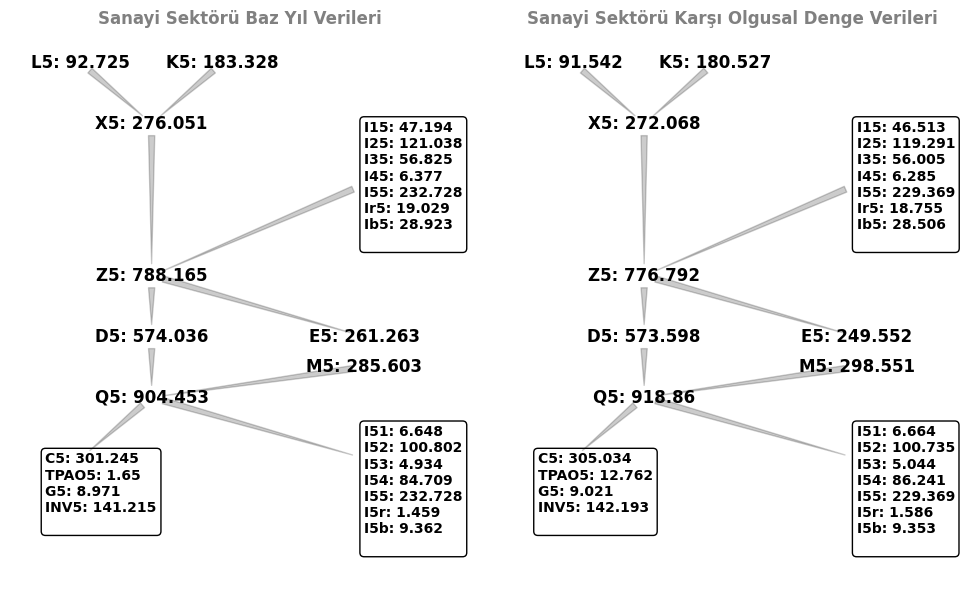

In [8]:
def flow_diagram(sector_code, BaserunResult, CfrunResult):
    
    # Sektör kou = 1: Tarım, 2: Ticaret ve hizmet, 3: Ulaşım, 4: İnşaat, 5: Sanayi
    
    sectors = {1: "Tarım", 2: "Ticaret Hizmet", 3: "Ulaşım", 4: "İnşaat", 5:"Sanayi"}
    
    values_base = []
    values_cfrun = []
    
    position = [(1,17), (3,17), (2,15), (5,13), 
            (2,10), (5,8), (2,8), (5,7), (2,6), 
            (1,4),
            (5,4)]
    
    variables1 = ["L", "K", "X", "I1", "I2", "I3", "I4", "I5", "Ir", "Ib",
                  "Z", "E", "D", "M", "Q", "C", "TPAO", "G", "INV",
                  "I_1", "I_2", "I_3", "I_4", "I_5", "I_r", "I_b"]
    
    variables = []
    for i in variables1:
        if "_" in i:
            val = i.replace("_", str(sector_code))
            variables.append(val)
        else:
            val = i + str(sector_code)
            variables.append(val)
            
    nodes1 = ["L", "K", "X", "I_cost",
             "Z", "E", "D", "M", "Q", "final",
             "I_income"]
   
    nodes = []
    for i in nodes1:
        if "_" in i:
            val = i.replace("_", str(sector_code))
            nodes.append(val)
        else:
            val = i + str(sector_code)
            nodes.append(val)
            

    Icost      = variables[3:10]
    Iincome    = variables[19:]
    final      = variables[15:19]
    
    for i in nodes:
        if i in CGE(SAM).init_values_str:
            values_base.append("{}: {}".format(i, BaserunResult[(CGE(SAM).init_values_str.index(i))]))
            values_cfrun.append("{}: {}".format(i, CfrunResult[(CGE(SAM).init_values_str.index(i))]))

        else:
            values_base.append("")
            values_cfrun.append("")
            
    val1_base = ""
    val1_cfrun = ""
    for y in Icost:
        val1_base = val1_base + y + ": " + str(BaserunResult[(CGE(SAM).init_values_str.index(y))]) + "\n"
        val1_cfrun = val1_cfrun + y + ": " + str(CfrunResult[(CGE(SAM).init_values_str.index(y))]) + "\n"


    val2_base = ""
    val2_cfrun = ""
    for y in Iincome:
        val2_base = val2_base + y + ": " + str(BaserunResult[(CGE(SAM).init_values_str.index(y))])+ "\n"
        val2_cfrun = val2_cfrun + y + ": " + str(CfrunResult[(CGE(SAM).init_values_str.index(y))]) + "\n"


    val3_base = ""
    val3_cfrun = ""
    for y in final:
        val3_base = val3_base + y + ": " + str(BaserunResult[(CGE(SAM).init_values_str.index(y))])+ "\n"  
        val3_cfrun = val3_cfrun + y + ": " + str(CfrunResult[(CGE(SAM).init_values_str.index(y))]) + "\n"
            
    
    edges1 = [("L", "X"), ("K", "X"),
    ("X", "Z"), ("I_cost", "Z"), ("Z", "E"),("Z", "D"), ("D", "Q"), ("M", "Q"),
    ("Q","final"),
    ("Q", "I_income")]
    
    edges = []
    
    for i in edges1:
        k = []
        
        for j in i:
            
            if "_" in j:
                val = j.replace("_", str(sector_code))
                k.append(val)
            else:
                val = j + str(sector_code)
                k.append(val)
        edges.append(tuple(k))

    G1 = nx.Graph()  
    G2 = nx.Graph()
        
    for k in range(len(nodes)):
        G1.add_node(nodes[k], pos = position[k], val = values_base[k])
        G2.add_node(nodes[k], pos = position[k], val = values_cfrun[k])
    
    pos1 = nx.get_node_attributes(G1,'pos')
    pos2 = nx.get_node_attributes(G2,'pos')
    
    labels1 = nx.get_node_attributes(G1,'val')
    labels2 = nx.get_node_attributes(G2,'val')
    
    G1.add_edges_from(edges)
    G2.add_edges_from(edges)
    
        
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

    nx.draw_networkx_nodes(G1, pos1, node_size = 1500, node_color = "none", ax = ax1)
    nx.draw_networkx_edges(G1, pos1, edgelist = G1.edges(), edge_color = "black", arrows = True,
                       arrowstyle = "wedge", alpha = 0.2, arrowsize = 15, ax = ax1);
    nx.draw_networkx_labels(G1, pos1,labels = labels1, font_weight = "bold", ax = ax1);
    
    nx.draw_networkx_nodes(G2, pos2, node_size = 1500, node_color = "none", ax = ax2)
    nx.draw_networkx_edges(G2, pos2, edgelist = G2.edges(), edge_color = "black", arrows = True,
                       arrowstyle = "wedge", alpha = 0.2, arrowsize = 15, ax = ax2);
    nx.draw_networkx_labels(G2, pos2,labels = labels2, font_weight = "bold", ax = ax2);
    

    ax1.text(5,11, val1_base, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    ax1.text(5,1, val2_base, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    ax1.text(.5,1.7, val3_base, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    
    ax2.text(5,11, val1_cfrun, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    ax2.text(5,1, val2_cfrun, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    ax2.text(.5,1.7, val3_cfrun, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
        
    
    ax1.set_title("{} Sektörü Baz Yıl Verileri".format(sectors[sector_code]), fontweight = "bold", 
                 color = "grey")
    ax2.set_title("{} Sektörü Karşı Olgusal Denge Verileri".format(sectors[sector_code]), fontweight = "bold",
                 color = "grey")
    
    ax1.set_xlim(xmin = 0, xmax = 6.5)
    ax1.set_ylim(ymin = 0, ymax = 18)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    
    ax2.set_xlim(xmin = 0, xmax = 6.5)
    ax2.set_ylim(ymin = 0, ymax = 18)
    
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
        
    plt.tight_layout()      
  
flow_diagram(5, m_baserun_result, m_cfrun_result)

### Rafineriler Model Akış Diyagramı

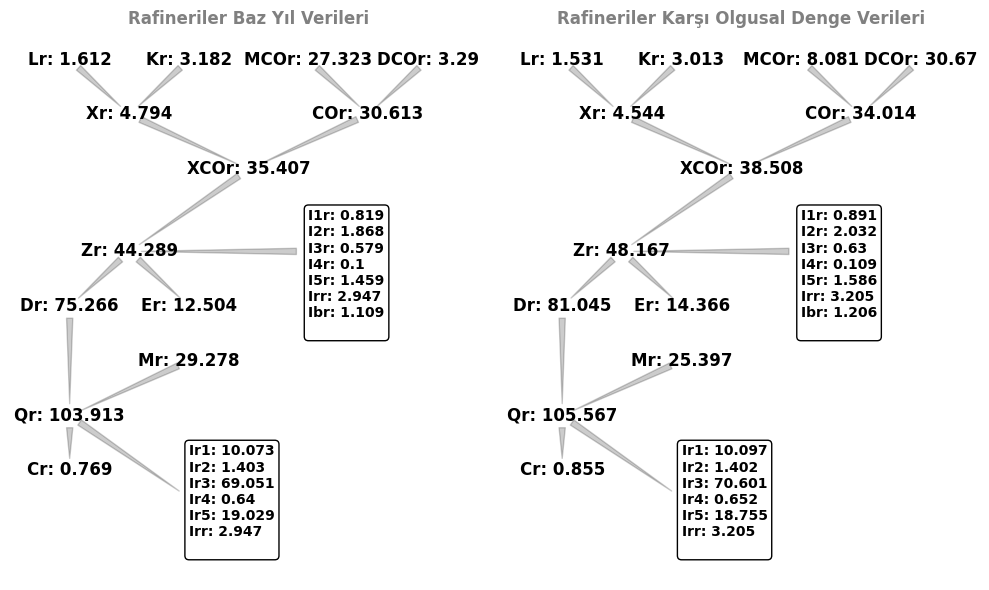

In [9]:
def flow_raf():   
    values_base = []
    values_cfrun = []

    position = [(1,19), (3,19), (2,17), 
                 (5,19), (7,19), (6,17),
                 (4,15), (5,12),
                 (2,12), (1,10), (3,10), (3,8), (1,6),
                 (1,4), (3,3)             
                ]

    variables = ["Lr", "Kr", "Xr",
                 "MCOr", "DCOr", "COr",
                 "XCOr", "I1r", "I2r", "I3r", "I4r", "I5r", "Irr", "Ibr",
                 "Zr", "Dr", "Er", "Mr", "Qr",
                 "Cr", "Ir1", "Ir2", "Ir3", "Ir4", "Ir5", "Irr"]

    nodes =  ["Lr", "Kr", "Xr",
               "MCOr", "DCOr", "COr",
               "XCOr", "I_cost",
               "Zr", "Dr", "Er", "Mr", "Qr",
               "Cr", "I_income"]

    Icost      = variables[7:14]
    Iincome    = variables[20:]



    for i in nodes:
            if i in CGE(SAM).init_values_str:
                values_base.append("{}: {}".format(i, m_baserun_result[(CGE(SAM).init_values_str.index(i))]))
                values_cfrun.append("{}: {}".format(i, m_cfrun_result[(CGE(SAM).init_values_str.index(i))]))

            else:
                values_base.append("")
                values_cfrun.append("")

    val1_base = ""
    val1_cfrun = ""
    for y in Icost:
        val1_base = val1_base + y + ": " + str(m_baserun_result[(CGE(SAM).init_values_str.index(y))]) + "\n"
        val1_cfrun = val1_cfrun + y + ": " + str(m_cfrun_result[(CGE(SAM).init_values_str.index(y))]) + "\n"


    val2_base = ""
    val2_cfrun = ""
    for y in Iincome:
        val2_base = val2_base + y + ": " + str(m_baserun_result[(CGE(SAM).init_values_str.index(y))])+ "\n"
        val2_cfrun = val2_cfrun + y + ": " + str(m_cfrun_result[(CGE(SAM).init_values_str.index(y))]) + "\n"


    edges = [
              ("Lr", "Xr"), ("Kr", "Xr"), ("MCOr", "COr"), ("DCOr", "COr"), ("Xr", "XCOr"), ("COr", "XCOr"),
              ("XCOr", "Zr"), ("I_cost", "Zr"), ("Zr", "Dr"), ("Zr", "Er"), ("Dr", "Qr"), ("Mr", "Qr"),("Qr", "Cr"), ("Qr", "I_income")

             ]   

    G1 = nx.Graph()  
    G2 = nx.Graph()

    for k in range(len(nodes)):
        G1.add_node(nodes[k], pos = position[k], val = values_base[k])
        G2.add_node(nodes[k], pos = position[k], val = values_cfrun[k])

    pos1 = nx.get_node_attributes(G1,'pos')
    pos2 = nx.get_node_attributes(G2,'pos')

    labels1 = nx.get_node_attributes(G1,'val')
    labels2 = nx.get_node_attributes(G2,'val')

    G1.add_edges_from(edges)
    G2.add_edges_from(edges)


    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

    nx.draw_networkx_nodes(G1, pos1, node_size = 1500, node_color = "none", ax = ax1)
    nx.draw_networkx_edges(G1, pos1, edgelist = G1.edges(), edge_color = "black", arrows = True,
                       arrowstyle = "wedge", alpha = 0.2, arrowsize = 15, ax = ax1);
    nx.draw_networkx_labels(G1, pos1,labels = labels1, font_weight = "bold", ax = ax1);

    nx.draw_networkx_nodes(G2, pos2, node_size = 1500, node_color = "none", ax = ax2)
    nx.draw_networkx_edges(G2, pos2, edgelist = G2.edges(), edge_color = "black", arrows = True,
                       arrowstyle = "wedge", alpha = 0.2, arrowsize = 15, ax = ax2);
    nx.draw_networkx_labels(G2, pos2,labels = labels2, font_weight = "bold", ax = ax2);


    ax1.text(5,9, val1_base, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    ax1.text(3,1, val2_base, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")

    ax2.text(5,9, val1_cfrun, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    ax2.text(3,1, val2_cfrun, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")



    ax1.set_title("Rafineriler Baz Yıl Verileri", fontweight = "bold", 
                 color = "grey")
    ax2.set_title("Rafineriler Karşı Olgusal Denge Verileri", fontweight = "bold",
                 color = "grey")

    ax1.set_xlim(xmin = 0, xmax = 8)
    ax1.set_ylim(ymin = 0, ymax = 20)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)

    ax2.set_xlim(xmin = 0, xmax = 8)
    ax2.set_ylim(ymin = 0, ymax = 20)

    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)

    plt.tight_layout()      

flow_raf()

### BOTAŞ Model Akış Diyagramı

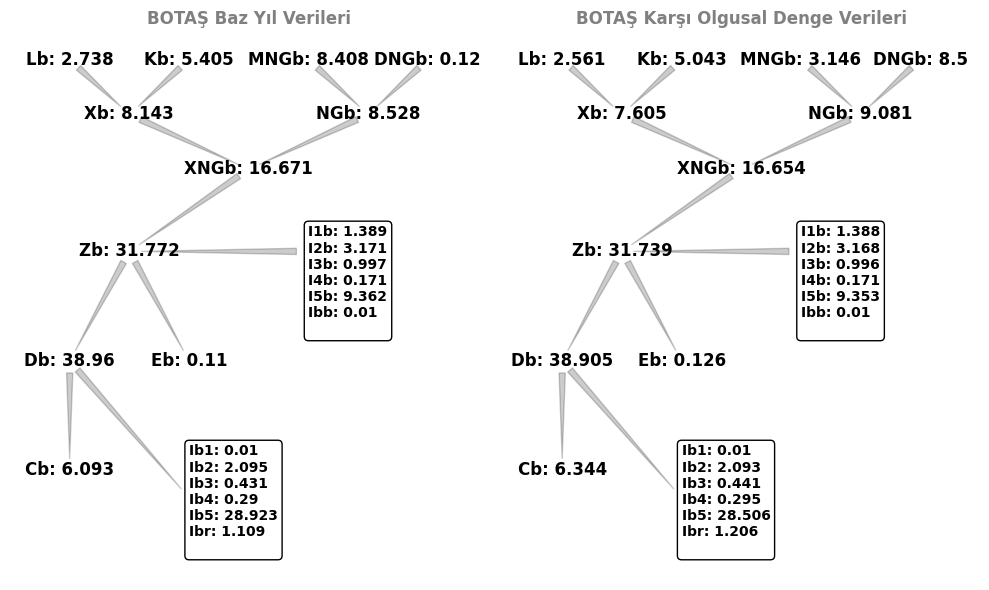

In [10]:
def flow_botas():   
    values_base = []
    values_cfrun = []

    position = [(1,19), (3,19), (2,17), 
                 (5,19), (7,19), (6,17),
                 (4,15), (5,12),
                 (2,12), (1,8), (3,8),
                 (1,4), (3,3)             
                ]

    variables = ["Lb", "Kb", "Xb",
                 "MNGb", "DNGb", "NGb",
                 "XNGb", "I1b", "I2b", "I3b", "I4b", "I5b", "Ibb",
                 "Zb", "Db", "Eb", 
                 "Cb", "Ib1", "Ib2", "Ib3", "Ib4", "Ib5", "Ibr"]

    nodes =  ["Lb", "Kb", "Xb",
               "MNGb", "DNGb", "NGb",
               "XNGb", "I_cost",
               "Zb", "Db", "Eb",
               "Cb", "I_income"]

    Icost      = variables[7:13]
    Iincome    = variables[17:]



    for i in nodes:
            if i in CGE(SAM).init_values_str:
                values_base.append("{}: {}".format(i, m_baserun_result[(CGE(SAM).init_values_str.index(i))]))
                values_cfrun.append("{}: {}".format(i, m_cfrun_result[(CGE(SAM).init_values_str.index(i))]))

            else:
                values_base.append("")
                values_cfrun.append("")

    val1_base = ""
    val1_cfrun = ""
    for y in Icost:
        val1_base = val1_base + y + ": " + str(m_baserun_result[(CGE(SAM).init_values_str.index(y))]) + "\n"
        val1_cfrun = val1_cfrun + y + ": " + str(m_cfrun_result[(CGE(SAM).init_values_str.index(y))]) + "\n"


    val2_base = ""
    val2_cfrun = ""
    for y in Iincome:
        val2_base = val2_base + y + ": " + str(m_baserun_result[(CGE(SAM).init_values_str.index(y))])+ "\n"
        val2_cfrun = val2_cfrun + y + ": " + str(m_cfrun_result[(CGE(SAM).init_values_str.index(y))]) + "\n"


    edges = [
              ("Lb", "Xb"), ("Kb", "Xb"), ("MNGb", "NGb"), ("DNGb", "NGb"), ("Xb", "XNGb"), ("NGb", "XNGb"),
              ("XNGb", "Zb"), ("I_cost", "Zb"), ("Zb", "Db"), ("Zb", "Eb"), ("Db", "Cb"), ("Db", "I_income")

             ]   

    G1 = nx.Graph()  
    G2 = nx.Graph()

    for k in range(len(nodes)):
        G1.add_node(nodes[k], pos = position[k], val = values_base[k])
        G2.add_node(nodes[k], pos = position[k], val = values_cfrun[k])

    pos1 = nx.get_node_attributes(G1,'pos')
    pos2 = nx.get_node_attributes(G2,'pos')

    labels1 = nx.get_node_attributes(G1,'val')
    labels2 = nx.get_node_attributes(G2,'val')

    G1.add_edges_from(edges)
    G2.add_edges_from(edges)


    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))

    nx.draw_networkx_nodes(G1, pos1, node_size = 1500, node_color = "none", ax = ax1)
    nx.draw_networkx_edges(G1, pos1, edgelist = G1.edges(), edge_color = "black", arrows = True,
                       arrowstyle = "wedge", alpha = 0.2, arrowsize = 15, ax = ax1);
    nx.draw_networkx_labels(G1, pos1,labels = labels1, font_weight = "bold", ax = ax1);

    nx.draw_networkx_nodes(G2, pos2, node_size = 1500, node_color = "none", ax = ax2)
    nx.draw_networkx_edges(G2, pos2, edgelist = G2.edges(), edge_color = "black", arrows = True,
                       arrowstyle = "wedge", alpha = 0.2, arrowsize = 15, ax = ax2);
    nx.draw_networkx_labels(G2, pos2,labels = labels2, font_weight = "bold", ax = ax2);


    ax1.text(5,9, val1_base, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    ax1.text(3,1, val2_base, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")

    ax2.text(5,9, val1_cfrun, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")
    ax2.text(3,1, val2_cfrun, fontsize = 10, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),fontweight = "bold")



    ax1.set_title("BOTAŞ Baz Yıl Verileri", fontweight = "bold", 
                 color = "grey")
    ax2.set_title("BOTAŞ Karşı Olgusal Denge Verileri", fontweight = "bold",
                 color = "grey")

    ax1.set_xlim(xmin = 0, xmax = 8)
    ax1.set_ylim(ymin = 0, ymax = 20)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)

    ax2.set_xlim(xmin = 0, xmax = 8)
    ax2.set_ylim(ymin = 0, ymax = 20)

    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)

    plt.tight_layout()    

flow_botas()

### Sektörler Yurtiçi üretim İthalat İhracat Grafik Göstreimler

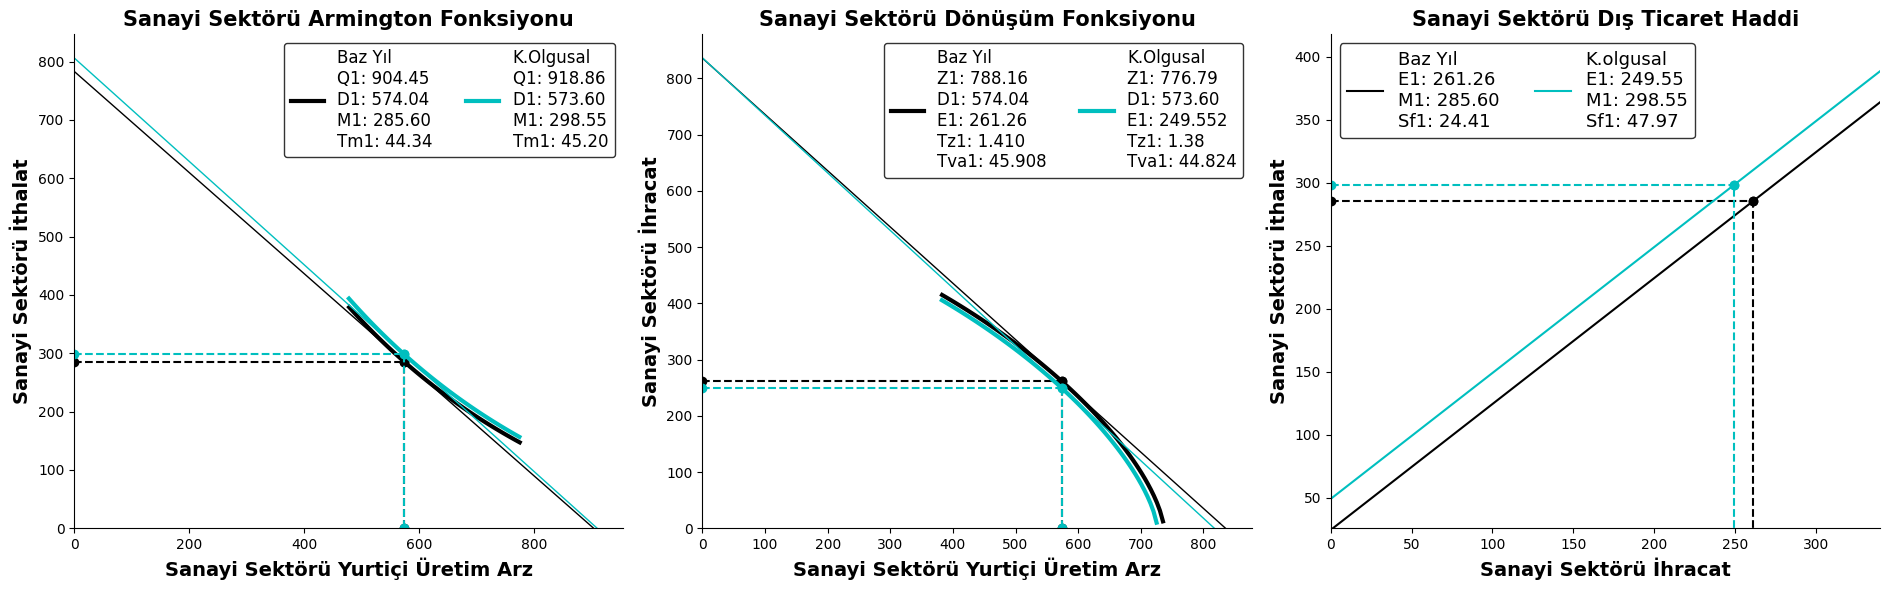

In [11]:
def plot_functions(sec_code, width, hight):  #sec_code = 1,2,3,4,5 girilebilir.
    
    sectors = {1: "Tarım", 2: "Ticaret Hizmet", 3: "Ulaşım", 4: "İnşaat", 5:"Sanayi"}
    
    Dbase      = [D1_base, D2_base, D3_base, D4_base, D5_base]
    Qbase      = [Q1_base, Q2_base, Q3_base, Q4_base, Q5_base]
    Mbase      = [M1_base, M2_base, M3_base, M4_base, M5_base]
    lambdabase = [lambda1_base, lambda2_base, lambda3_base, lambda4_base, lambda5_base,]
    etabase    = [eta1_base, eta2_base, eta3_base, eta4_base, eta5_base,]
    mbase      = [m1_base, m2_base, m3_base, m4_base, m5_base,]
    dabase     = [da1_base, da2_base, da3_base, da4_base, da5_base,]
    pqbase     = [pq1_base, pq2_base, pq3_base, pq4_base, pq5_base,]
    pdbase     = [pd1_base, pd2_base, pd3_base, pd4_base, pd5_base,]
    pmbase     = [pm1_base, pm2_base, pm3_base, pm4_base, pm5_base,]
    tmbase     = [tm1_base, tm2_base, tm3_base, tm4_base, tm5_base,]
    Tmbase     = [Tm1_base, Tm2_base, Tm3_base, Tm4_base, Tm5_base,]
    Tvabase     = [Tva1_base, Tva2_base, Tva3_base, Tva4_base, Tva5_base,]
    Tzbase     = [Tz1_base, Tz2_base, Tz3_base, Tz4_base, Tz5_base,]
    
    Zbase      = [Z1_base, Z2_base, Z3_base, Z4_base, Z5_base]
    Ebase      = [E1_base, E2_base, E3_base, E4_base, E5_base]
    thetabase  = [theta1_base, theta2_base, theta3_base, theta4_base, theta5_base]
    rhobase    = [rho1_base, rho2_base, rho3_base, rho4_base, rho5_base]
    ebase      = [e1_base, e2_base, e3_base, e4_base, e5_base]
    dtbase     = [dt1_base, dt2_base, dt3_base, dt4_base, dt5_base]
    tzbase     = [tz1_base, tz2_base, tz3_base, tz4_base, tz5_base]
    tvabase    = [tva1_base, tva2_base, tva3_base, tva4_base, tva5_base]
    pzbase     = [pz1_base, pz2_base, pz3_base, pz4_base, pz5_base]
    pebase     = [pe1_base, pe2_base, pe3_base, pe4_base, pe5_base]
    
    Dcfrun      = [D1_cfrun, D2_cfrun, D3_cfrun, D4_cfrun, D5_cfrun]
    Qcfrun      = [Q1_cfrun, Q2_cfrun, Q3_cfrun, Q4_cfrun, Q5_cfrun]
    Mcfrun      = [M1_cfrun, M2_cfrun, M3_cfrun, M4_cfrun, M5_cfrun]
    lambdacfrun = [lambda1_cfrun, lambda2_cfrun, lambda3_cfrun, lambda4_cfrun, lambda5_cfrun,]
    etacfrun    = [eta1_cfrun, eta2_cfrun, eta3_cfrun, eta4_cfrun, eta5_cfrun,]
    mcfrun      = [m1_cfrun, m2_cfrun, m3_cfrun, m4_cfrun, m5_cfrun,]
    dacfrun     = [da1_cfrun, da2_cfrun, da3_cfrun, da4_cfrun, da5_cfrun,]
    pqcfrun     = [pq1_cfrun, pq2_cfrun, pq3_cfrun, pq4_cfrun, pq5_cfrun,]
    pdcfrun     = [pd1_cfrun, pd2_cfrun, pd3_cfrun, pd4_cfrun, pd5_cfrun,]
    pmcfrun     = [pm1_cfrun, pm2_cfrun, pm3_cfrun, pm4_cfrun, pm5_cfrun,]
    tmcfrun     = [tm1_cfrun, tm2_cfrun, tm3_cfrun, tm4_cfrun, tm5_cfrun,]
    Tmcfrun     = [Tm1_cfrun, Tm2_cfrun, Tm3_cfrun, Tm4_cfrun, Tm5_cfrun,]
    Tvacfrun     = [Tva1_cfrun, Tva2_cfrun, Tva3_cfrun, Tva4_cfrun, Tva5_cfrun,]
    Tzcfrun     = [Tz1_cfrun, Tz2_cfrun, Tz3_cfrun, Tz4_cfrun, Tz5_cfrun,]
    
    Zcfrun      = [Z1_cfrun, Z2_cfrun, Z3_cfrun, Z4_cfrun, Z5_cfrun]
    Ecfrun      = [E1_cfrun, E2_cfrun, E3_cfrun, E4_cfrun, E5_cfrun]
    thetacfrun  = [theta1_cfrun, theta2_cfrun, theta3_cfrun, theta4_cfrun, theta5_cfrun]
    rhocfrun    = [rho1_cfrun, rho2_cfrun, rho3_cfrun, rho4_cfrun, rho5_cfrun]
    ecfrun      = [e1_cfrun, e2_cfrun, e3_cfrun, e4_cfrun, e5_cfrun]
    dtcfrun     = [dt1_cfrun, dt2_cfrun, dt3_cfrun, dt4_cfrun, dt5_cfrun]
    tzcfrun     = [tz1_cfrun, tz2_cfrun, tz3_cfrun, tz4_cfrun, tz5_cfrun]
    tvacfrun    = [tva1_cfrun, tva2_cfrun, tva3_cfrun, tva4_cfrun, tva5_cfrun]
    pzcfrun     = [pz1_cfrun, pz2_cfrun, pz3_cfrun, pz4_cfrun, pz5_cfrun]
    pecfrun     = [pe1_cfrun, pe2_cfrun, pe3_cfrun, pe4_cfrun, pe5_cfrun]
   
    
    arm_1_x_base = np.linspace(Dbase[sec_code-1] / 1.2, Dbase[sec_code-1]*1.35, 100)
    arm_1_y_base = ( (Qbase[sec_code-1] / lambdabase[sec_code-1])**etabase[sec_code-1] * 1/mbase[sec_code-1] - dabase[sec_code-1]/mbase[sec_code-1] * arm_1_x_base**etabase[sec_code-1])**(1/etabase[sec_code-1])

    arm_1_x_cfrun = np.linspace(Dcfrun[sec_code-1] / 1.2, Dcfrun[sec_code-1]*1.35, 100)
    arm_1_y_cfrun = ( (Qcfrun[sec_code-1] / lambdacfrun[sec_code-1])**etacfrun[sec_code-1] * 1/mcfrun[sec_code-1] - dacfrun[sec_code-1]/mcfrun[sec_code-1] * arm_1_x_cfrun**etacfrun[sec_code-1])**(1/etacfrun[sec_code-1])
   
    arm_budget_1_x_base = np.linspace(0, pqbase[sec_code-1]*Qbase[sec_code-1] / pdbase[sec_code-1], 100)
    arm_budget_1_y_base = pqbase[sec_code-1]*Qbase[sec_code-1] / (pmbase[sec_code-1] * (1+tmbase[sec_code-1])) - pdbase[sec_code-1] / (pmbase[sec_code-1] * (1+tmbase[sec_code-1])) * arm_budget_1_x_base

    arm_budget_1_x_cfrun = np.linspace(0, pqcfrun[sec_code-1]*Qcfrun[sec_code-1] / pdcfrun[sec_code-1], 100)
    arm_budget_1_y_cfrun = pqcfrun[sec_code-1]*Qcfrun[sec_code-1] / (pmcfrun[sec_code-1] * (1+tmcfrun[sec_code-1])) - pdcfrun[sec_code-1] / (pmcfrun[sec_code-1] * (1+tmcfrun[sec_code-1])) * arm_budget_1_x_cfrun

    #-----------------------------------------

    trs_1_x_base = np.linspace(Dbase[sec_code-1] / 1.5, Dbase[sec_code-1]*1.5, 100)
    trs_1_y_base = ( (Zbase[sec_code-1] / thetabase[sec_code-1])**rhobase[sec_code-1] * 1/ebase[sec_code-1] - dtbase[sec_code-1]/ebase[sec_code-1] * trs_1_x_base**rhobase[sec_code-1])**(1/rhobase[sec_code-1])

    trs_1_x_cfrun = np.linspace(Dcfrun[sec_code-1] / 1.5, Dcfrun[sec_code-1]*1.5, 100)
    trs_1_y_cfrun = ( (Zcfrun[sec_code-1] / thetacfrun[sec_code-1])**rhocfrun[sec_code-1] * 1/ecfrun[sec_code-1] - dtcfrun[sec_code-1]/ecfrun[sec_code-1] * trs_1_x_cfrun**rhocfrun[sec_code-1])**(1/rhocfrun[sec_code-1])

    trs_budget_1_x_base = np.linspace(0, (1+tzbase[sec_code-1] + tvabase[sec_code-1])*pzbase[sec_code-1]*Zbase[sec_code-1] / pdbase[sec_code-1], 100)
    trs_budget_1_y_base = ((1+tzbase[sec_code-1] + tvabase[sec_code-1])*pzbase[sec_code-1]*Zbase[sec_code-1]) / pebase[sec_code-1] - pdbase[sec_code-1] / pebase[sec_code-1] * trs_budget_1_x_base


    trs_budget_1_x_cfrun = np.linspace(0, (1+tzcfrun[sec_code-1] + tvacfrun[sec_code-1])*pzcfrun[sec_code-1]*Zcfrun[sec_code-1] / pdcfrun[sec_code-1], 100)
    trs_budget_1_y_cfrun = ((1+tzcfrun[sec_code-1] + tvacfrun[sec_code-1])*pzcfrun[sec_code-1]*Zcfrun[sec_code-1]) / pecfrun[sec_code-1] - pdcfrun[sec_code-1] / pecfrun[sec_code-1] * trs_budget_1_x_cfrun

    #---------------------------------------------------------------

    Sf1_base = Mbase[sec_code-1]*pmbase[sec_code-1] - Ebase[sec_code-1]*pebase[sec_code-1]
    trade_line_1_x_base = np.linspace(0, Ebase[sec_code-1]*2, 99)
    trade_line_1_y_base = Sf1_base / pmbase[sec_code-1] + pebase[sec_code-1]/pmbase[sec_code-1] * trade_line_1_x_base

    Sf1_cfrun = Mcfrun[sec_code-1]*pmcfrun[sec_code-1] - Ecfrun[sec_code-1]*pecfrun[sec_code-1]
    trade_line_1_x_cfrun = np.linspace(0, Ecfrun[sec_code-1]*2, 99)
    trade_line_1_y_cfrun = Sf1_cfrun / pmcfrun[sec_code-1] + pecfrun[sec_code-1]/pmcfrun[sec_code-1] * trade_line_1_x_cfrun

    #----------------------------------------------------------------

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (width, hight))
    
    label_base_arm =  "Baz Yıl\nQ1: {:.2f}\nD1: {:.2f}\nM1: {:.2f}\nTm1: {:.2f}".format(Qbase[sec_code-1], Dbase[sec_code-1], Mbase[sec_code-1], Tmbase[sec_code-1])
    ax1.plot(arm_1_x_base, arm_1_y_base, "-k", linewidth = 3, label = label_base_arm)
    ax1.plot(arm_budget_1_x_base, arm_budget_1_y_base, "-k", linewidth = 1)
    ax1.plot([Dbase[sec_code-1], Dbase[sec_code-1]], [0, Mbase[sec_code-1]], "--ok")
    ax1.plot([0, Dbase[sec_code-1]], [Mbase[sec_code-1], Mbase[sec_code-1]], "--ok")

    label_cfrun_arm =  "K.Olgusal\nQ1: {:.2f}\nD1: {:.2f}\nM1: {:.2f}\nTm1: {:.2f}".format(Qcfrun[sec_code-1], Dcfrun[sec_code-1], Mcfrun[sec_code-1], Tmcfrun[sec_code-1])
    ax1.plot(arm_1_x_cfrun, arm_1_y_cfrun, "-c", linewidth = 3, label = label_cfrun_arm)
    ax1.plot(arm_budget_1_x_cfrun, arm_budget_1_y_cfrun, "-c", linewidth = 1)
    ax1.plot([Dcfrun[sec_code-1], Dcfrun[sec_code-1]], [0, Mcfrun[sec_code-1]], "--oc")
    ax1.plot([0, Dcfrun[sec_code-1]], [Mcfrun[sec_code-1], Mcfrun[sec_code-1]], "--oc")


    ax1.set_xlabel("{} Sektörü Yurtiçi Üretim Arz".format(sectors[sec_code]), fontweight = "bold", fontsize = 14),
    ax1.set_ylabel("{} Sektörü İthalat".format(sectors[sec_code]), fontweight = "bold", fontsize = 14)
    ax1.set_title("{} Sektörü Armington Fonksiyonu".format(sectors[sec_code]), fontweight = "bold", fontsize = 15)
    ax1.legend(fontsize = 12, edgecolor = "black", ncol = 2)


    #-------------------------------------------------------------------

    label_base_trs =  "Baz Yıl\nZ1: {:.2f}\nD1: {:.2f}\nE1: {:.2f}\nTz1: {:.3f}\nTva1: {:.3f}".format(Zbase[sec_code-1], Dbase[sec_code-1], Ebase[sec_code-1], Tzbase[sec_code-1], Tvabase[sec_code-1])
    ax2.plot(trs_1_x_base, trs_1_y_base, "-k", linewidth = 3, label = label_base_trs)
    ax2.plot(trs_budget_1_x_base, trs_budget_1_y_base, "-k", linewidth = 1)
    ax2.plot([Dbase[sec_code-1], Dbase[sec_code-1]], [0, Ebase[sec_code-1]], "--ok")
    ax2.plot([0, Dbase[sec_code-1]], [Ebase[sec_code-1], Ebase[sec_code-1]], "--ok")

    label_cfrun_trs =  "K.Olgusal\nZ1: {:.2f}\nD1: {:.2f}\nE1: {:.3f}\nTz1: {:.2f}\nTva1: {:.3f}".format(Zcfrun[sec_code-1], Dcfrun[sec_code-1], Ecfrun[sec_code-1], Tzcfrun[sec_code-1], Tvacfrun[sec_code-1])
    ax2.plot(trs_1_x_cfrun, trs_1_y_cfrun, "-c", linewidth = 3, label =  label_cfrun_trs)
    ax2.plot(trs_budget_1_x_cfrun, trs_budget_1_y_cfrun, "-c", linewidth = 1)
    ax2.plot([Dcfrun[sec_code-1], Dcfrun[sec_code-1]], [0, Ecfrun[sec_code-1]], "--oc")
    ax2.plot([0, Dcfrun[sec_code-1]], [Ecfrun[sec_code-1], Ecfrun[sec_code-1]], "--oc")

    ax2.set_xlabel("{} Sektörü Yurtiçi Üretim Arz".format(sectors[sec_code]), fontweight = "bold", fontsize = 14),
    ax2.set_ylabel("{} Sektörü İhracat".format(sectors[sec_code]), fontweight = "bold", fontsize = 14)
    ax2.set_title("{} Sektörü Dönüşüm Fonksiyonu".format(sectors[sec_code]), fontweight = "bold", fontsize = 15)
    ax2.legend(fontsize = 12, edgecolor = "black", ncol = 2)

    #-----------------------------------------------------------------------

    label_base_trade =  "Baz Yıl\nE1: {:.2f}\nM1: {:.2f}\nSf1: {:.2f}".format(Ebase[sec_code-1], Mbase[sec_code-1],Sf1_base)
    ax3.plot(trade_line_1_x_base,trade_line_1_y_base, "-k", label = label_base_trade)
    ax3.plot([Ebase[sec_code-1], Ebase[sec_code-1]], [0, Mbase[sec_code-1]], "--ok")
    ax3.plot([0, Ebase[sec_code-1]], [Mbase[sec_code-1], Mbase[sec_code-1]], "--ok")

    label_cfrun_trade =  "K.olgusal\nE1: {:.2f}\nM1: {:.2f}\nSf1: {:.2f}".format(Ecfrun[sec_code-1], Mcfrun[sec_code-1],Sf1_cfrun)
    ax3.plot(trade_line_1_x_cfrun,trade_line_1_y_cfrun, "-c", label = label_cfrun_trade)
    ax3.plot([Ecfrun[sec_code-1], Ecfrun[sec_code-1]], [0, Mcfrun[sec_code-1]], "--oc")
    ax3.plot([0, Ecfrun[sec_code-1]], [Mcfrun[sec_code-1], Mcfrun[sec_code-1]], "--oc")

    ax3.set_xlabel("{} Sektörü İhracat".format(sectors[sec_code]), fontweight = "bold", fontsize = 14),
    ax3.set_ylabel("{} Sektörü İthalat".format(sectors[sec_code]), fontweight = "bold", fontsize = 14)
    ax3.set_title("{} Sektörü Dış Ticaret Haddi".format(sectors[sec_code]), fontweight = "bold", fontsize = 15)
    ax3.legend(fontsize = 13, ncol = 2, edgecolor = "black", loc = "best")
    
    
    ax3.axhline(y=0, linewidth = 1, color = "black")
    if Sf1_base < Sf1_cfrun:
        ax3.set_ylim(ymin = Sf1_base*1.05)
    else:
        ax3.set_ylim(ymin = Sf1_cfrun*1.05)

    if Mbase[sec_code-1] > Mcfrun[sec_code-1]:
        ax3.set_ylim(ymax = Mbase[sec_code-1]*1.4)
    else:
        ax3.set_ylim(ymax = Mcfrun[sec_code-1]*1.4)    

    if Ebase[sec_code-1] > Ecfrun[sec_code-1]:
        ax3.set_xlim(xmin = 0, xmax = Ebase[sec_code-1]*1.3)
    else:
        ax3.set_xlim(xmin = 0, xmax = Ecfrun[sec_code-1]*1.3)    
        

    arm_1_x_base = np.linspace(Dbase[sec_code-1] / 1.2, Dbase[sec_code-1]*1.35, 100)
    arm_1_y_base = ( (Qbase[sec_code-1] / lambdabase[sec_code-1])**etabase[sec_code-1] * 1/mbase[sec_code-1] - dabase[sec_code-1]/mbase[sec_code-1] * arm_1_x_base**etabase[sec_code-1])**(1/etabase[sec_code-1])

    arm_1_x_cfrun = np.linspace(Dcfrun[sec_code-1] / 1.2, Dcfrun[sec_code-1]*1.35, 100)
    arm_1_y_cfrun = ( (Qcfrun[sec_code-1] / lambdacfrun[sec_code-1])**etacfrun[sec_code-1] * 1/mcfrun[sec_code-1] - dacfrun[sec_code-1]/mcfrun[sec_code-1] * arm_1_x_cfrun**etacfrun[sec_code-1])**(1/etacfrun[sec_code-1])
   
    arm_budget_1_x_base = np.linspace(0, pqbase[sec_code-1]*Qbase[sec_code-1] / pdbase[sec_code-1], 100)
    arm_budget_1_y_base = pqbase[sec_code-1]*Qbase[sec_code-1] / (pmbase[sec_code-1] * (1+tmbase[sec_code-1])) - pdbase[sec_code-1] / (pmbase[sec_code-1] * (1+tmbase[sec_code-1])) * arm_budget_1_x_base

    arm_budget_1_x_cfrun = np.linspace(0, pqcfrun[sec_code-1]*Qcfrun[sec_code-1] / pdcfrun[sec_code-1], 100)
    arm_budget_1_y_cfrun = pqcfrun[sec_code-1]*Qcfrun[sec_code-1] / (pmcfrun[sec_code-1] * (1+tmcfrun[sec_code-1])) - pdcfrun[sec_code-1] / (pmcfrun[sec_code-1] * (1+tmcfrun[sec_code-1])) * arm_budget_1_x_cfrun



    ax1.set_xlim(xmin=0)
    ax1.set_ylim(ymin = 0)

    ax2.set_xlim(xmin = 0)
    ax2.set_ylim(ymin = 0)
    
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)

    plt.tight_layout()

plot_functions(5, 19, 6)    

### Sektörler Emek Sermaye Kullanımları Grafik Gösterim

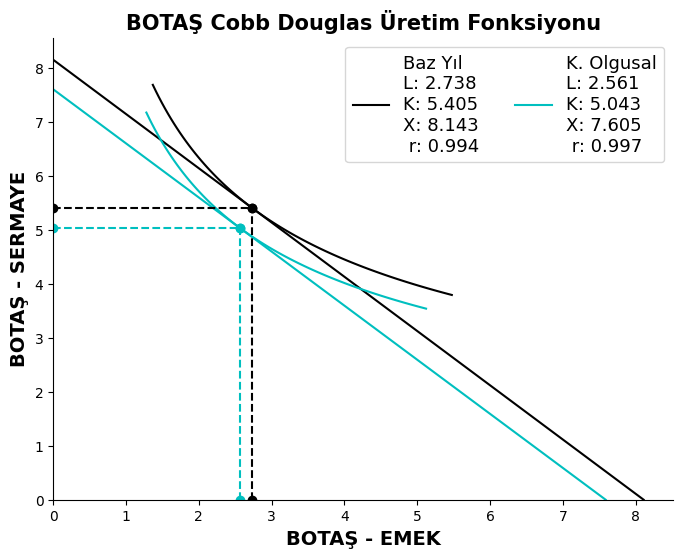

In [12]:
def plot_cobb_douglass(sec_code): # sec_code = 1,2,3,4,5,6,7 girilebilir.
    
    Lbase = [L1_base, L2_base, L3_base, L4_base, L5_base, Lr_base, Lb_base]
    Kbase = [K1_base, K2_base, K3_base, K4_base, K5_base, Kr_base, Kb_base]
    Xbase = [X1_base, X2_base, X3_base, X4_base, X5_base, Xr_base, Xb_base]
    Abase = [A1_base, A2_base, A3_base, A4_base, A5_base, Ar_base, Ab_base ]
    alphakbase = [alphak1_base, alphak2_base, alphak3_base, alphak4_base, alphak5_base, alphakr_base, alphakb_base]
    alphalbase = [alphal1_base, alphal2_base, alphal3_base, alphal4_base, alphal5_base, alphalr_base, alphalb_base]
    
    Lcfrun = [L1_cfrun, L2_cfrun, L3_cfrun, L4_cfrun, L5_cfrun, Lr_cfrun, Lb_cfrun]
    Kcfrun = [K1_cfrun, K2_cfrun, K3_cfrun, K4_cfrun, K5_cfrun, Kr_cfrun, Kb_cfrun]
    Xcfrun = [X1_cfrun, X2_cfrun, X3_cfrun, X4_cfrun, X5_cfrun, Xr_cfrun, Xb_cfrun]
    Acfrun = [A1_cfrun, A2_cfrun, A3_cfrun, A4_cfrun, A5_cfrun, Ar_cfrun, Ab_cfrun ]
    alphakcfrun = [alphak1_cfrun, alphak2_cfrun, alphak3_cfrun, alphak4_cfrun, alphak5_cfrun, alphakr_cfrun, alphakb_cfrun]
    alphalcfrun = [alphal1_cfrun, alphal2_cfrun, alphal3_cfrun, alphal4_cfrun, alphal5_cfrun, alphalr_cfrun, alphalb_cfrun]
    

    sectors = {1: "Tarım", 2: "Ticaret Hizmet", 3: "Ulaşım", 4: "İnşaat", 5:"Sanayi", 6:"Rafineriler", 7: "BOTAŞ"}
    
    production_line_base_x = np.linspace(Lbase[sec_code - 1] / 2, Lbase[sec_code - 1]*2, 100)
    production_line_base_y = Xbase[sec_code - 1] ** (1/alphakbase[sec_code - 1]) / (Abase[sec_code - 1]**(1/alphakbase[sec_code - 1]) * production_line_base_x ** (alphalbase[sec_code - 1] / alphakbase[sec_code - 1]))


    production_line_cfrun_x = np.linspace(Lcfrun[sec_code - 1] / 2, Lcfrun[sec_code - 1]*2, 100)
    production_line_cfrun_y = Xcfrun[sec_code - 1] ** (1/alphakcfrun[sec_code - 1]) / (Acfrun[sec_code - 1]**(1/alphakcfrun[sec_code - 1]) * production_line_cfrun_x ** (alphalcfrun[sec_code - 1] / alphakcfrun[sec_code - 1]))


    Cr_base  = 1*Lbase[sec_code - 1] + Kbase[sec_code - 1]*r_base
    Cr_cfrun = 1*Lcfrun[sec_code - 1] + Kcfrun[sec_code - 1]*r_cfrun

    cost_line_base_x = np.linspace(0, Cr_base/1)
    cost_line_base_y = Cr_base / r_base - (1 / r_base) * cost_line_base_x

    cost_line_cfrun_x = np.linspace(0, Cr_cfrun/1)
    cost_line_cfrun_y = Cr_cfrun / r_cfrun - (1 / r_cfrun) * cost_line_cfrun_x

    fig,ax = plt.subplots(figsize = (8,6))

    label_base = "Baz Yıl\nL: {}\nK: {}\nX: {}\n r: {}".format(Lbase[sec_code - 1], Kbase[sec_code - 1], Xbase[sec_code - 1], r_base)
    ax.plot(production_line_base_x, production_line_base_y, "-k", label = label_base)
    ax.plot(cost_line_base_x, cost_line_base_y, "-k")

    label_cfrun = "K. Olgusal\nL: {}\nK: {}\nX: {}\n r: {}".format(Lcfrun[sec_code - 1], Kcfrun[sec_code - 1], Xcfrun[sec_code - 1], r_cfrun)
    ax.plot(production_line_cfrun_x, production_line_cfrun_y, "-c", label = label_cfrun)
    ax.plot(cost_line_cfrun_x, cost_line_cfrun_y, "-c")

    ax.plot([Lbase[sec_code - 1], Lbase[sec_code - 1]], [0, Kbase[sec_code - 1]], "--ok")
    ax.plot([0, Lbase[sec_code - 1]], [Kbase[sec_code - 1], Kbase[sec_code - 1]], "--ok")

    ax.plot([Lcfrun[sec_code - 1], Lcfrun[sec_code - 1]], [0, Kcfrun[sec_code - 1]], "--oc")
    ax.plot([0, Lcfrun[sec_code - 1]], [Kcfrun[sec_code - 1], Kcfrun[sec_code - 1]], "--oc")
    ax.legend(fontsize = 13, ncol = 2)


    ax.set_xlabel("{} - EMEK".format(sectors[sec_code]), fontsize = 14, fontweight = "bold")
    ax.set_ylabel("{} - SERMAYE".format(sectors[sec_code]), fontsize = 14, fontweight = "bold")
    ax.set_title("{} Cobb Douglas Üretim Fonksiyonu".format(sectors[sec_code]), fontsize = 15, fontweight = "bold")


    ax.set_xlim(xmin = 0)
    ax.set_ylim(ymin = 0)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

plot_cobb_douglass(7)

### Rafineriler ve BOTAŞ Enerji Üretimi (CES Fonksiyonu)

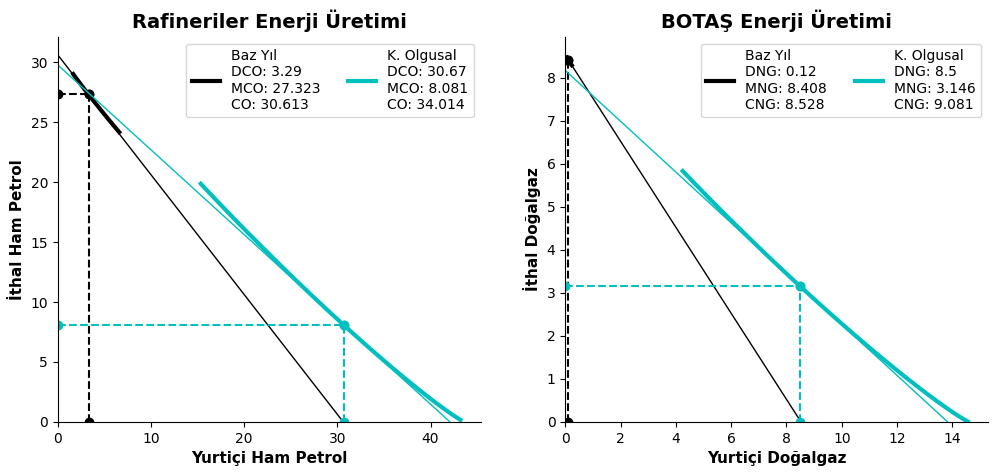

In [13]:
def Raf_Bot_Energy_Pro():

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
    ########################################################### RAFİNERİLER ###############################################################################

    enj_co_fun_x_base = np.linspace(DCOr_base/2, DCOr_base*2, 100)
    enj_co_fun_y_base = ((COr_base / lambdaco_base)**etaco_base * 1 / mcor_base - (dcor_base / mcor_base)*enj_co_fun_x_base**(etaco_base)) **(1/etaco_base) 

    enj_co_fun_x_cfrun = np.linspace(DCOr_cfrun/2, DCOr_cfrun*2, 100)
    enj_co_fun_y_cfrun = ((COr_cfrun / lambdaco_cfrun)**etaco_cfrun * 1 / mcor_cfrun - (dcor_cfrun / mcor_cfrun)*enj_co_fun_x_cfrun**(etaco_cfrun)) **(1/etaco_cfrun) 

    enj_co_cost_x_base = np.linspace(0, pco_base * COr_base / pdco_base, 100)
    enj_co_cost_y_base = (pco_base * COr_base / pmco_base) - (pdco_base / pmco_base) * enj_co_cost_x_base

    enj_co_cost_x_cfrun = np.linspace(0, pco_cfrun * COr_cfrun / pdco_cfrun, 100)
    enj_co_cost_y_cfrun = (pco_cfrun * COr_cfrun / pmco_cfrun) - (pdco_cfrun / pmco_cfrun) * enj_co_cost_x_cfrun

    label_base_co = "Baz Yıl\nDCO: {}\nMCO: {}\nCO: {}".format(DCOr_base, MCOr_base, COr_base)
    ax1.plot(enj_co_fun_x_base, enj_co_fun_y_base, "-k", linewidth = 3, label = label_base_co)
    ax1.plot(enj_co_cost_x_base, enj_co_cost_y_base, "-k", linewidth = 1)
    ax1.plot([DCOr_base, DCOr_base],[0, MCOr_base], "--ok")
    ax1.plot([0, DCOr_base],[MCOr_base, MCOr_base], "--ok")

    label_cfrun_co = "K. Olgusal\nDCO: {}\nMCO: {}\nCO: {}".format(DCOr_cfrun, MCOr_cfrun, COr_cfrun)
    ax1.plot(enj_co_fun_x_cfrun, enj_co_fun_y_cfrun, "-c", linewidth = 3, label = label_cfrun_co)
    ax1.plot(enj_co_cost_x_cfrun, enj_co_cost_y_cfrun, "-c", linewidth = 1)
    ax1.plot([DCOr_cfrun, DCOr_cfrun],[0, MCOr_cfrun], "--oc")
    ax1.plot([0, DCOr_cfrun],[MCOr_cfrun, MCOr_cfrun], "--oc")

    ax1.set_xlim(xmin = 0)
    ax1.set_ylim(ymin = 0)

    ax1.set_xlabel("Yurtiçi Ham Petrol", fontsize = 11, fontweight = "bold")
    ax1.set_ylabel("İthal Ham Petrol", fontsize = 11, fontweight = "bold")
    ax1.set_title("Rafineriler Enerji Üretimi", fontsize = 14, fontweight = "bold")
    ax1.legend(fontsize = 10, ncol = 2)

    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)

    ########################################################### BOTAŞ ##########################################################################################

    enj_ng_fun_x_base = np.linspace(DNGb_base/2, DNGb_base*2, 100)
    enj_ng_fun_y_base = ((NGb_base / lambdang_base)**etang_base * 1 / mngb_base - (dngb_base / mngb_base)*enj_ng_fun_x_base**(etang_base)) **(1/etang_base) 

    enj_ng_fun_x_cfrun = np.linspace(DNGb_cfrun/2, DNGb_cfrun*2, 100)
    enj_ng_fun_y_cfrun = ((NGb_cfrun / lambdang_cfrun)**etang_cfrun * 1 / mngb_cfrun - (dngb_cfrun / mngb_cfrun)*enj_ng_fun_x_cfrun**(etang_cfrun)) **(1/etang_cfrun) 

    enj_ng_cost_x_base = np.linspace(0, png_base * NGb_base / pdng_base, 100)
    enj_ng_cost_y_base = (png_base * NGb_base / pmng_base) - (pdng_base / pmng_base) * enj_ng_cost_x_base

    enj_ng_cost_x_cfrun = np.linspace(0, png_cfrun * NGb_cfrun / pdng_cfrun, 100)
    enj_ng_cost_y_cfrun = (png_cfrun * NGb_cfrun / pmng_cfrun) - (pdng_cfrun / pmng_cfrun) * enj_ng_cost_x_cfrun

    label_base_ng = "Baz Yıl\nDNG: {}\nMNG: {}\nCNG: {}".format(DNGb_base, MNGb_base, NGb_base)
    ax2.plot(enj_ng_fun_x_base, enj_ng_fun_y_base, "-k", linewidth = 3, label = label_base_ng)
    ax2.plot(enj_ng_cost_x_base, enj_ng_cost_y_base, "-k", linewidth = 1)
    ax2.plot([DNGb_base, DNGb_base],[0, MNGb_base], "--ok")
    ax2.plot([0, DNGb_base],[MNGb_base, MNGb_base], "--ok")

    label_cfrun_ng = "K. Olgusal\nDNG: {}\nMNG: {}\nCNG: {}".format(DNGb_cfrun, MNGb_cfrun, NGb_cfrun)
    ax2.plot(enj_ng_fun_x_cfrun, enj_ng_fun_y_cfrun, "-c", linewidth = 3,label = label_cfrun_ng )
    ax2.plot(enj_ng_cost_x_cfrun, enj_ng_cost_y_cfrun, "-c", linewidth = 1)
    ax2.plot([DNGb_cfrun, DNGb_cfrun],[0, MNGb_cfrun], "--oc")
    ax2.plot([0, DNGb_cfrun],[MNGb_cfrun, MNGb_cfrun], "--oc")


    ax2.set_xlim(xmin = 0)
    ax2.set_ylim(ymin = 0)


    ax2.set_xlabel("Yurtiçi Doğalgaz", fontsize = 11, fontweight = "bold")
    ax2.set_ylabel("İthal Doğalgaz", fontsize = 11, fontweight = "bold")
    ax2.set_title("BOTAŞ Enerji Üretimi", fontsize = 14, fontweight = "bold")
    ax2.legend(fontsize = 10, ncol = 2)

    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)

Raf_Bot_Energy_Pro()

### Rafineriler ve BOTAŞ Kompozit Enerji Üretimi (Cobb Douglas Fonksiyonu)

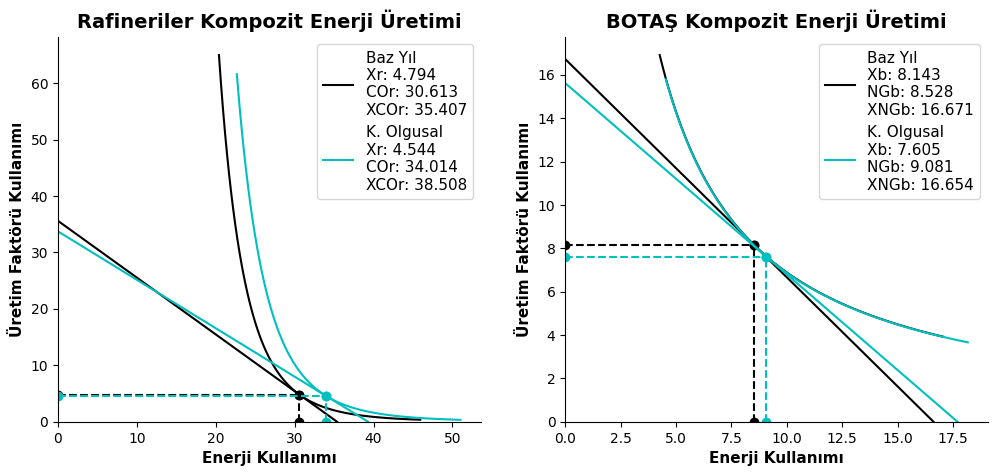

In [14]:
def Raf_Bot_ComFac_Pro():

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

    ########################################################### RAFİNERİLER ###############################################################################

    production_line_base_x_raf = np.linspace(COr_base / 1.5, COr_base*1.5, 100)
    production_line_base_y_raf = XCOr_base**(1/alphaxr_base) / Axco_base ** (1/alphaxr_base) * 1 / (production_line_base_x_raf ** (alphaco_base / alphaxr_base))

    production_line_cfrun_x_raf = np.linspace(COr_cfrun / 1.5, COr_cfrun*1.5, 100)
    production_line_cfrun_y_raf = XCOr_cfrun**(1/alphaxr_cfrun) / Axco_cfrun ** (1/alphaxr_cfrun) * 1 / (production_line_cfrun_x_raf ** (alphaco_cfrun / alphaxr_cfrun))

    C_base_raf = Xr_base*pxr_base + COr_base * pco_base
    C_cfrun_raf = Xr_cfrun*pxr_cfrun + COr_cfrun * pco_cfrun

    cost_line_base_x_raf = np.linspace(0, C_base_raf/pco_base)
    cost_line_base_y_raf = C_base_raf / pxr_base - (pco_base/pxr_base) * cost_line_base_x_raf

    cost_line_cfrun_x_raf = np.linspace(0, C_cfrun_raf/pco_cfrun)
    cost_line_cfrun_y_raf = C_cfrun_raf / pxr_cfrun - (pco_cfrun/pxr_cfrun) * cost_line_cfrun_x_raf

    label_base_raf = "Baz Yıl\nXr: {}\nCOr: {}\nXCOr: {}".format(Xr_base, COr_base, XCOr_base)
    ax1.plot(production_line_base_x_raf, production_line_base_y_raf, "-k", label = label_base_raf)
    ax1.plot(cost_line_base_x_raf, cost_line_base_y_raf, "-k")
    ax1.plot([COr_base, COr_base], [0, Xr_base], "--ok")
    ax1.plot([0, COr_base], [Xr_base, Xr_base], "--ok")

    label_cfrun_raf = "K. Olgusal\nXr: {}\nCOr: {}\nXCOr: {}".format(Xr_cfrun, COr_cfrun, XCOr_cfrun)
    ax1.plot(production_line_cfrun_x_raf, production_line_cfrun_y_raf, "-c", label = label_cfrun_raf)
    ax1.plot(cost_line_cfrun_x_raf, cost_line_cfrun_y_raf, "-c")
    ax1.plot([COr_cfrun, COr_cfrun], [0, Xr_cfrun], "--oc")
    ax1.plot([0, COr_cfrun], [Xr_cfrun, Xr_cfrun], "--oc")

    ax1.set_xlabel("Enerji Kullanımı", fontsize = 11, fontweight = "bold")
    ax1.set_ylabel("Üretim Faktörü Kullanımı", fontsize = 11, fontweight = "bold")
    ax1.set_title("Rafineriler Kompozit Enerji Üretimi", fontsize = 14, fontweight = "bold")
    ax1.legend(fontsize = 11)

    ax1.set_xlim(xmin = 0)
    ax1.set_ylim(ymin = 0)

    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)

    ########################################################### BOTAŞ ###############################################################################

    production_line_base_x_bot = np.linspace(NGb_base/2,NGb_base*2, 100 )
    production_line_base_y_bot = XNGb_base ** (1/alphaxb_base) / Axng_base**(1/alphaxb_base) * 1/(production_line_base_x_bot**(alphang_base / alphaxb_base))

    production_line_cfrun_x_bot = np.linspace(NGb_cfrun/2,NGb_cfrun*2, 100 )
    production_line_cfrun_y_bot = XNGb_cfrun ** (1/alphaxb_cfrun) / Axng_cfrun**(1/alphaxb_cfrun) * 1/(production_line_cfrun_x_bot**(alphang_cfrun / alphaxb_cfrun))


    C_base_bot = Xb_base * pxb_base + NGb_base * png_base
    C_cfrun_bot = Xb_cfrun * pxb_cfrun + NGb_cfrun * png_cfrun


    cost_line_base_x_bot = np.linspace(0, C_base_bot / png_base, 100)
    cost_line_base_y_bot = C_base_bot / pxb_base - (png_base / pxb_base) * cost_line_base_x_bot

    cost_line_cfrun_x_bot = np.linspace(0, C_cfrun_bot / png_cfrun, 100)
    cost_line_cfrun_y_bot = C_cfrun_bot / pxb_cfrun - (png_cfrun / pxb_cfrun) * cost_line_cfrun_x_bot

    label_base_bot = "Baz Yıl\nXb: {}\nNGb: {}\nXNGb: {}".format(Xb_base, NGb_base, XNGb_base)
    ax2.plot(production_line_base_x_bot,production_line_base_y_bot, "-k", label = label_base_bot)
    ax2.plot(cost_line_base_x_bot,cost_line_base_y_bot, "-k" )
    ax2.plot([NGb_base, NGb_base], [0, Xb_base], "--ok")
    ax2.plot([0, NGb_base], [Xb_base, Xb_base], "--ok")

    label_cfrun_bot = "K. Olgusal\nXb: {}\nNGb: {}\nXNGb: {}".format(Xb_cfrun, NGb_cfrun, XNGb_cfrun)
    ax2.plot(production_line_cfrun_x_bot,production_line_cfrun_y_bot, "-c", label = label_cfrun_bot)
    ax2.plot(cost_line_cfrun_x_bot,cost_line_cfrun_y_bot, "-c" )
    ax2.plot([NGb_cfrun, NGb_cfrun], [0, Xb_cfrun], "--oc")
    ax2.plot([0, NGb_cfrun], [Xb_cfrun, Xb_cfrun], "--oc")


    ax2.set_xlim(xmin = 0)
    ax2.set_ylim(ymin = 0)

    ax2.set_xlabel("Enerji Kullanımı", fontsize = 11, fontweight = "bold")
    ax2.set_ylabel("Üretim Faktörü Kullanımı", fontsize = 11, fontweight = "bold")
    ax2.set_title("BOTAŞ Kompozit Enerji Üretimi", fontsize = 14, fontweight = "bold")
    ax2.legend(fontsize = 11)

    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)

Raf_Bot_ComFac_Pro()